# Lab 2: Unsupervised Learning - Recommendation System
---


In [ ]:
# necessary installations
!pip install --upgrade pip  --user
!pip install --upgrade numpy --user
!pip install --upgrade pandas --user
!pip install --upgrade nltk --user
!pip install --upgrade scikit-learn --user
!pip install --upgrade joblib --user
!pip install --upgrade num2words --user
!pip install --upgrade gensim --user 


In [216]:
# Import Libraries

import nltk
nltk.download('omw-1.4')
#download file containing stopwords in english 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


import pandas as pd
import numpy as np
import re
import contractions

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

import urllib
from sklearn.feature_extraction.text import TfidfVectorizer


import scipy
import gensim.downloader as api
from scipy.sparse import csr_matrix
import joblib
import somoclu
import matplotlib
from sklearn.cluster import KMeans

import string
import scipy as sp
import gensim.downloader as api
import textwrap

[nltk_data] Error loading omw-1.4: <urlopen error [WinError 10054] An
[nltk_data]     existing connection was forcibly closed by the remote
[nltk_data]     host>
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\meglr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\meglr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\meglr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [217]:
#######################################
##### useful help functions ###########
#######################################

def isEnglish(inputString):
    """
    input : inputString (string)
    output:
        returns true if inputString contains english alphabet letters, numbers, punctuation marks or a combination of the above
        returns false otherwise (eg. if inputString contains chinese ideograms)
    """
    try:
        inputString.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

def has_numbers(inputString):
    """
    input : inputString (string)
    output : 
        returns true if inputString contains numbers (0-9)
        returns false otherwise
    """
    return bool(re.search(r'\d', inputString))

def has_punctuation(inputString):
    """
    input : inputString (string)
    output : 
        returns true if inputString contains any punctuation mark
        returns false otherwise
    """
    punctuation_marks = set(string.punctuation)
    return any(p in inputString for p in punctuation_marks)

def get_names(url):
    decoded_url = urllib.request.urlopen(url).read().decode()
    name_list = decoded_url.split('\n')
    names = []
    for name in name_list:
        if isEnglish(name) and not has_numbers(name) and not has_punctuation(name):
           names.append(name)
    names.append("T.J.")  #add name "T.J."
    names.append("Michael")
    return list(names)

## Εισαγωγή του Dataset

Στο σύνολο δεδομένων με το οποίο θα δουλέψουμε η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset στο dataframe `df_data_1`.

In [218]:
dataset_url = "https://drive.google.com/uc?export=download&id=1zo13kUAf-MDMPZmBDxq1FxWtZY01lsxD"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3)

Θα δουλέψουμε σε **ένα μοναδικό υποσύνολο 5.000 ταινιών** (διαφορετικό dataset για κάθε ομάδα) το οποίο επιλέγουμε με τον έτοιμο κώδικα που δίνεται. Τρέχοντάς τον προκύπτουν τα titles, categories, catbins, summaries και corpus με τα οποία θα δουλέψουμε.

In [219]:
# Στο επόμενη γραμή βάλτε τον αριθμό της ομάδας στο εργαστήριο των νευρωνικών
team_seed_number = 79

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1g6F4TCHrs2wgtdOk7D3gtONaeirNt_Vo"
df_data_2 = pd.read_csv(movie_seeds_url, header=None)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries
corpus_df = pd.DataFrame(corpus) # dataframe version of corpus

- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. 
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. 
- το dataframe corpus_df που είναι απλά το corpus σε μορφή dataframe. Τα summaries βρίσκονται στην κολόνα 0. Πιθανώς να σας βολεύει να κάνετε κάποιες προεπεξεργασίες με dataframes.


Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. 

## Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
---

Η πρώτη εφαρμογή που θα αναπτύξετε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξετε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). 


## Προεπεξεργασία

Το πρώτο βήμα στην επεξεργασία μας είναι ο καθαρισμός των περιγραφών των ταινιών. 

Εκτυπώστε (αρκετές) διαφορετικές περιγραφές ταινιών για να δείτε πιθανά προβλήματα που θα πρέπει να αντιμετωπιστούν.

Τα (ελάχιστα) βήματα καθαρισμού που προτείνουμε είναι:
- μετατροπή όλων των χαρακτήρων σε πεζά,
- αφαίρεση των stopwords. Εδώ σημειώστε ότι για το δεδομένο task του συστήματος συστάσεων που είναι η πρόταση ταινιών ίσως θα είχαν ενδιαφέρον και λίστες stopwords πέραν αυτών της κοινής γλώσσας.
- αφαίρεση σημείων στίξης και ειδικών χαρακτρήρων (special characters). Αυτό δεν γίνεται μόνο με την punkt του NLTK. Θα μπορούσατε να βασιστείτε σε κανονικές εκφράσεις (regular expressions), και
- αφαίρεση πολυ σύντομων συμβολοσειρών.

Προσοχή: το corpus και τα τελικά tokens που θα το αποτελούν θα χρησιμοποιηθούν στη συνέχεια ως κλειδιά για να βρούμε εμφυτεύματα. Για το λόγο αυτό, πρέπει να είστε προσεκτικοί ως προς την εφαρμογή μεθόδων κανονικοποίησης (text normalization) όπως το stemming και το lemmatization.

In [220]:
#dataframe with summaries (index the id of each movie)
pd.options.display.max_colwidth = 600
corpus_df

,0
0,"The Ready When You Are, Mr McGill story is centered around the filming of a movie. A television actor-extra is finally given a line to say to camera. While filming, a collection of comical mishaps occur to create chaos on-set."
1,"The film opens with two common thugs, Brian Hope and Charlie McManus pulling off a bank heist with their mob, but their boss is killed and replaced with a new, rather brash one, Mr. ""Case"" Casey. Disapproving of Casey's methods, Brian and Charlie wish to leave, and a corrupt auto dealer, Norm, on Casey's payroll, desiring the same, tells Casey of this. Casey kills Norm to make an example of him, apparently intending to spare Brian and Charlie. Meanwhile, Brian meets and begins a romantic relationship with Faith Thomas , a short sighted aspiring psychology student. Brian and Charlie ultim..."
2,"Bosko is having a nice day while Honey is struggling dealing with her cat-like son. Bosko comes home and is asked by Honey if he can watch her son but Bosko is not thrilled with the idea. Bosko keeps trying to entertain the child by telling stories and imitating celebrities who famous at their time, but the kid keeps complaining that he wants an ice cream cone. Honey then arrives back home with an ice cream cone, but Bosko accidentally hits the ice cream with an umbrella. The kid gets mad and complains as the cartoon ends."
3,"The film opens with Brad , an out of work musician, making a cup of latte for his wife Lexi who is still in bed. She soon leaves for work and Brad is left at home alone. Over the radio he hears that several suspected dirty bombs have been detonated across Los Angeles. He exits his house and sees large amounts of smoke rising from the city center and gets into his car to drive towards the city center in order to find her. Brad tries to contact her through her cell phone, but only receives a busy signal. He soon finds that most roads now have police blockades. An ash covered car is stopped..."
4,"Katrien is dumped by her boyfriend, high school rugby star Werner , so he can focus his energy on the sport. To get even, she makes a bet with her friends that she can make a star out of the school's dorkiest boy, Wimpie Koekemoer , by pretending to be his girlfriend. The awkward Koekemoer rises to the challenge but Katrien finds herself falling unexpectedly in love with him, until he realizes she is merely using him."
...,...
4995,"The story takes place in a second-rate boarding school run by the tyrannical and mean Michel Delassalle . The school, though, is owned by Delassalle's teacher wife, the frail Christina , and Delassalle flaunts his relationship with Nicole Horner , a teacher at the school. Rather than antagonism, the two women are shown to have a somewhat close relationship, primarily based on their apparent common hatred of Michel, who is physically and emotionally abusive to both. Unable to stand his mistreatment any longer, Nicole devises a plan. Though hesitant at first, Christina ultimately consents to..."
4996,"Wheezer's mother and father continue to fight in an unconvincing and thoroughly hammy fashion over many different silly things, such as the coffee being too cold or the toast being burned. Wheezer overhears his father telling his mother that he is getting her a divorce. Not knowing what a divorce is, Wheezer tells Stymie, Dorothy, and Sherwood. They speculate on what a divorce means, at one point deciding it might be something good. Then Donald tells the gang what a divorce is, and people start sobbing. He even tells Wheezer that he will have no father anymore. His mother might either rema..."
4997,"The telefilm starts with the mayor as Norm the Genie with his new master. He wishes for a sandwich, and then to be mayor of the world. Eventually, he angers the citizens and is about to be put in a guillotine. Norm, who has come up with an evil plan, gives a note to the mayor and tells him to say it. It says to wish that everything was back to normal and Norm was in the 

In [221]:
# Εκτυπώνουμε μερικές περιλήψεις ώστε να εντοπίσουμε 
# επιπλέον stopwords που θα μας ήταν χρήσιμα πέραν των "standard"
# (βλέπε παρακάτω για πληροφορίες για το βήμα αφαίρεσης stopwords από τις περιγραφές)

print(corpus[31])

In 1991, it is three years since a massive flying saucer carrying 300,000 enslaved aliens, the "Newcomers", landed in the Mojave Desert. Los Angeles, California has become the new home of the aliens. As a part of their integration into society they have been assigned human names, often well known ones such as Harley Davidson and Humphrey Bogart. Many humans discriminate against the aliens, calling them  'Slags'  and the ghettos where they live as  'Slagtown' . LAPD Det. Matthew Sykes  encounters two Newcomers murdering another named Cecil Porter  in an apparent convenience store robbery. Sykes' partner Bill Tuggle  is killed in the ensuing gunfight - in return fire Sykes kills one of the robbers, but the second escapes. The next day, Captain Warner  informs his squad they will have Newcomer detective Samuel Francisco  joining them and that he needs a partner. Although a specist, Sykes volunteers to work with Francisco in investigating the murder of Newcomer Warren Hubley as he hopes th

#### **Προεπεξεργασία Κειμένου**:
Στο στάδιο της προεπεξεργασίας του corpus ακολουθήσαμε τα βήματα που ακολουθούν.
(stopwords, καθαρισμός, stemming ή μη). 

Καταρχάς, πρέπει να προσδιορίσουμε **stopwords**, δηλαδή λέξεις που δεν συνεισφέρουν σημαντικά στο περιεχόμενο ενός κειμένου και άρα ούτε στην ταξινόμηση του με βάση αυτό. Θα εκμεταλλευτούμε την βιβλιοθήκη `nltk.corpus` που παρέχει κάποια standard stopwords της αγγλικής γλώσσας (πχ him, herself, them, κτλ). Πέραν αυτών θα συμπεριλάβουμε στα stopwords και κάποιες λέξεις που συνηθίζονται γενικά στις περιγραφές ταινιών και δεν προσφέρουν στην ταξινόμησή τους (π.χ. plot, film, protagonist, κτλ). Θα παραλείψουμε επίσης ονόματα (τα ποιο συνηθισμένα της αγγλικής γλώσσας) καθώς δεν θέλουμε το σύστημα συστάσεων να βρίσκει ομοιότητα μεταξύ ταινιών που περιέχουν χαρακτήρες με το ίδιο όνομα και έχουν εντελώς διαφορετικό περιεχόμενο πλοκής.

In [222]:
# stopword compilation 
# (words that are going to be removed)

# standard stopwords FROM nltk library
common_stopwords = set(stopwords.words('english'))


# common words specifically in film descriptions 
# that might not be included in the above stopwords
movie_stopwords = {"movie", "film", "story",'episode', "plot","era", 'hero','protagonist',
                'finale','summary','city','village','family',
                'main','secondary','cinema', 'people', 'person',} 


names = get_names("https://www.usna.edu/Users/cs/roche/courses/s15si335/proj1/files.php%3Ff=names.txt.html")

country_names = get_names("https://gist.githubusercontent.com/kalinchernev/486393efcca01623b18d/raw/daa24c9fea66afb7d68f8d69f0c4b8eeb9406e83/countries")

custom_common =  ["n't", "'s", "’", "–", "film", "movie", "people", "person", "episode"]

STOPWORDS = set.union(common_stopwords , movie_stopwords)

print(f"Note: \nWe are going to recognize and remove {len(names)} common English names. Some rarer names will not and could cause performance issues.")

Note: 
We are going to recognize and remove 18240 common English names. Some rarer names will not and could cause performance issues.


Έχοντας ορίσει το σύνολο των stopwords προβαίνουμε στα επόμενα βήματα καθαρισμού του corpus. Αφαιρούμε και 
* αριθμητικές συμβολοσειρές, 
* μη αγγλικές συμβολοσειρές,
* πολύ μικρές η πολύ μεγάλες συμβολοσειρές (συνήθως πρόκειται για συντακτικά λάθη στις περιγραφές ή στοιχεία του λόγου που δεν μας βοηθάνε όπως π.χ. άρθρα, κτλ),
* URLs,
* συμβολοσειρές που περιέχουν σημεία στίξης.

Η προεπεξεργασία εξηγείται αναλυτικότερα παρακάτω σε μορφή σχολίων για κάθε βήμα της.




In [223]:
#################################################################
#################################################################
### Function for Text PREPROCESSING of each movie description ###
#################################################################
#################################################################

def cleaned_tokenized(s, stopwords = STOPWORDS, names = names, min_word_len = 3, max_word_len = 16, stem = True):

    """
    input: 
        s: a film description (string)
        stopwords, names (sets for efficiency purposes)
    
    returns tokenized input string description 
    it removes stopwords, names, 
    all words having length smaller than min_word_len and larger than max_word_len
    + "cleans" it from unwanted "occurences" that could have a negative affect on recommender performance
    """

    # use **REGULAR expressions** to remove 

    # remove url links from corpus 
    s = re.sub(r"http\S+", '', s)
    s = re.sub(r"www.\S+", '', s)
    s = re.sub(r"\S+.com", '', s)


    # replace \r and \n with ' '
    s = re.sub(re.compile("\\r\\n"), ' ', s) 

    #remove ordinal, time numerical expressions (eg 1rst, .., 4th, 12am, 12pm, etc)
    s = re.sub(r'\d{1,2}(?:st|nd|rd|th|am|pm)', "", s)
    
    # e.g. pirate's --> pirate
    s = re.sub(re.compile("\'s"), ' ', s)    
    
    # e.g. don't -> do not, you're -> you are
    s = contractions.fix(s)  
    
    # strip multiple whitespace
    s = re.sub("\s+", " ", s)  

    # tokenize (string of description -> words)
    tokens = list(word_tokenize(s))

    # ----------------------------------------------------------

    # punctuation marks need to be removed
    # be careful to remove more than 1 contained in each word

    punctuation_marks = set(string.punctuation)

    tokens = [token for token in tokens if (token not in punctuation_marks 
                                            and not "|" in token  #remove string like "McNary|titleVariety|date2008-10-09"  (*)
                                            and not "=" in token  #remove string like "accessdate=2009-08-20"   (*)
                                            )
            ]

    
    tokens_cleaned = []
    for token in tokens:
        #gather all letters contained in token
        #if there are any then keep token (else if token contains only punctuation marks discard)
        if(len([letter for letter in token if letter not in punctuation_marks]) > 0):
                tokens_cleaned.append(token)
    
    # update tokens list
    tokens = tokens_cleaned



    # "X.X" -> "X", "X"
    tokens_cleaned = []
    for token in tokens:
        if "." in token:
            try:
                part1, part2 = token.split(".")
                tokens_cleaned.extend([part1, part2])
            except: 
                # I might want to keep words like Ph.D. or L.A. but in most cases
                # words with more than one "." would provide little or no help so I remove them 
                # they usually are names of places (eg. L.A., D.C.) or people 
                # or time annotations (eg. a.m.)
                # (this we find out by printing them to get an idea of the ones
                # that appear more frequently in movie descriptions)
                continue
                #print(token)
                #tokens_cleaned.append(token) 
        else:
            tokens_cleaned.append(token)

    # update tokens list
    tokens = tokens_cleaned

    # "X-X" -> "X", "X"
    tokens_cleaned = []

    for token in tokens:
        if "-" in token:
            parts = token.split("-")
            # if all parts are numeric (=> date in form X-X-X) ignore token
            # even if there are some strings it is probably an expression referring 
            # to age (eg. 17-year-old) or a model (eg. Chanel-6) 
            # so again we ignore them
            # now, if all parts are strings keep initial token (eg keep "father-in-law")
            # this is useful so we keep the meaning of such expressions 
            # without having to use ngrams later on which add quite a lot of features (=> not "practical" to use them for SOM later)

            if (len([part for part in parts if not part.isnumeric()]) == len(parts)):
                tokens_cleaned.append(token)
                
            else:
                #print(parts)
                tokens_cleaned.extend(parts)

            tokens_cleaned.extend(parts)
 
        else:
            tokens_cleaned.append(token)

    # update tokens list
    tokens = tokens_cleaned

    # ----------------------------------------------------------
    
    # stemming

    if stem:
        stemmer = SnowballStemmer('english')
    
    # ----------------------------------------------------------

    # remove names
    # note : we do not include them in stopwords because 
    # in contrast to them we want to 
    # find and remove names before we convert all letters to lowercase
    # (this way it is more likely that we do not confuse eg. "Bill" as in person with "bill" as in invoice)

        tokens = [stemmer.stem(w) for w in tokens if w not in names and w not in country_names] 
    #same for country names

    else:
        
        tokens = [w for w in tokens if w not in names and w not in country_names] 

    # concatenate tokens back to string (so the following 2 
    # preprocessing procedures can be conducted easily)

    s = " ".join(tokens) 
    
    # convert to lowercase
    s = s.lower()  
    
    # keep only lowercase letters and spaces
    s = re.sub(r"[^a-zA-Z\s]", " ", s)  

    
    #tokenize again 
    tokens = list(word_tokenize(s))

    # remove stopwords and non english words and numbers
    # (we do not eg. Chinese ideograms)
    # also too small and too large words
    tokens = [token for token in tokens 
                              if (len(token) >= min_word_len) and 
                                 (len(token) <= max_word_len) and
                                 (token not in stopwords) and
                                 (isEnglish(token)) and     
                                 (not token.isnumeric()) 
    ]

    return " ".join(tokens)



# (*) : printing such tokens we get: 
# '|title2008-09-19|work=NY', '|', '2007|date', '|titleThe', '|location19', '|accessdate65', '|publisher=National', '|publisher', '|accessdate=August', 'belltower.jpg|Bell', 'barge.jpg|Barge', 'shock|date2008-03-31|workLeander|last', 'Sun|date2008-04-01', 
# "kwaad'|language", '|-', '|', '|', '|-', '|', '|', '|titleDetour', '|accessdate=2008-05-16' 'Buckmaster|date29','cs=1']
# this is pretty telling of the fact that such tokens are a result of "mistyped" summaries which confirms our suspicions => no need to keep them

Εφαρμόζουμε και stemming (για το σύστημα συστάσεων βασισμένο μόνο στο tfidf). Για την δημιουργία των embedding χρησιμοποιούμε προεπεξεργασμένο corpus χωρίς stemming. **Δεν εφαρμόζουμε stemming** για να μην προκαλέσουμε προβλήματα κατά χρήση προεκπαιδευμένων embeddings. Επειδή κάποιες stemmed λέξεις δεν υπάρχουν στο embedding, θα γίνουν "assigned" στο default μηδενικό διάνυσμα. Θα μπορούσαμε να εφαρμόσουμε lemmatization. Όμως στην πλειοψηφία των σχετικών research papers δεν θεωρείται απαραίτητο ειδικά όταν χρησιμοποιούμε "powerful contextualised" embeddings και σε γλώσσες με απλή μορφολογία (όπως είναι η αγγλική). Έτσι δεν εφαρμόζουμε ούτε lemmatization.

In [224]:
# testing our function in a couple of movie descriptions (change id to apply it to other movie descriptions)
print(cleaned_tokenized(corpus[2953]))

live live girlfriend appear enjoy perfect relationship pregnant prior open parent pressur pair get marri claim work pressur dissert render inopportun time marriag real reason unbeknownst anyon feel trap scare although consid panion harbor second thought upon chanc encount wed meet confid relationship guess break flirtati intrigu youth open spirit doe succumb temptat two part way tell attend school usual hang eventu seek memori union tell area onli becaus client meet sens interest drive home invit parti accept back offic construct excus away night parti ask friend work worker cover case call suspect met anoth woman wish avoid ing involv left wife know first hand pain breakup deni exist anoth woman mere say old colleg friend parti kim say make feel ten year younger two kiss sever time preced invit dorm night guilt cheat prevail temptat howev refus unfortun izzi father die night sever friend acquaint includ izzi home condol realiz claim confront refus answer question onli fuel suspicion i

Αποθήκευση / Loading των προεπεξεργασμένων περιγραφών ταινιών

(με και χωρίς stemming)

In [335]:
# if it already exists load it 
# else apply the preprocessing function and save the result as pickle
try:
    clean_corpus = joblib.load('clean_corpus.pkl')
    print("Preprocessed corpus loaded ...")
except (OSError, IOError):
    # Apply preprocessing function to each summary of corpus
    clean_corpus = []
    for corpus_ in corpus:
        #remove words smaller that 3 or larger than 20
        clean_corpus.append(cleaned_tokenized(corpus_, STOPWORDS))
    print("Preprocessing completed!")
    joblib.dump(clean_corpus, 'clean_corpus.pkl')
    print("Saved result (as pickle) in ./clean_corpus.pkl")

Preprocessed corpus loaded ...


In [226]:
# if it already exists load it 
# else apply the preprocessing function and save the result as pickle
try:
    clean_corpus_no_stem = joblib.load('clean_corpus_no_stem.pkl')
    print("Preprocessed corpus loaded (no stemming) ...")
except (OSError, IOError):
    # Apply preprocessing function to each summary of corpus
    clean_corpus_no_stem = []
    for corpus_ in corpus:
        #remove words smaller that 3 or larger than 20
        clean_corpus_no_stem.append(cleaned_tokenized(corpus_, STOPWORDS, stem = False))
    print("Preprocessing completed! No stemming applied!")
    joblib.dump(clean_corpus_no_stem, 'clean_corpus_no_stem.pkl')
    print("Saved result (as pickle) in ./clean_corpus_no_stem.pkl")

Preprocessed corpus loaded (no stemming) ...


In [227]:
print(clean_corpus[31])

three year sinc massiv fli saucer carri enslav alien land mojav desert los california new home alien part integr societi assign human name often well known one bogart mani human discrimin alien call slag ghetto live slagtown lapd det syke encount two murder anoth name appar conveni store robberi syke partner tuggl kill ensu gunfight return fire syke kill one robber second escap next day captain inform squad detect join need partner although specist syke volunt work investig murder hubley hope provid opportun find partner killer alreadi inform syke hubley kill rare ammunit syke nicknam new partner make sound much like assign robberi murder case detect fedorchuk alterez crime lab detect abnorm one dead crimin request addit test run interview son syke nightclub call encount discuss link homicid strader howev instead end talk girlfriend strader murder businessman harcourt henchman rudyard kipl second present murder strader kill immers sea water high corros dure later investig syke attempt 

In [228]:
print(clean_corpus_no_stem[31])

three years since massive flying saucer carrying enslaved aliens ers landed mojave desert los california new home aliens part integration society assigned human names often well known ones bogart many humans discriminate aliens calling slags ghettos live slagtown lapd det sykes encounters two ers murdering another named apparent convenience store robbery sykes partner tuggle killed ensuing gunfight return fire sykes kills one robbers second escapes next day captain informs squad detective joining needs partner although specist sykes volunteers work investigating murder hubley hopes provide opportunity find partner killer already informed sykes hubley killed rare ammunition sykes nicknames new partner makes sound much like assigns robbery murder case detectives fedorchuk alterez crime lab detects abnormality one dead criminals requests additional test run interviewing son sykes nightclub called encounters discuss link homicides strader however instead end talking girlfriend strader murd

## Μετατροπή Corpus σε αναπαράσταση TFIDF


In [229]:
# create sparse tf_idf representation
vectorizer = TfidfVectorizer()
vectorizer.fit(clean_corpus)
corpus_tf_idf_basic = vectorizer.transform(clean_corpus).toarray()

Η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται εδώ **δεν είναι βελτιστοποιημένη**. Οι επιλογές των μεθόδων και παραμέτρων της μπορεί να έχουν **δραματική επίδραση στην ποιότητα των συστάσεων** και είναι διαφορετικές για κάθε dataset. Επίσης, οι επιλογές αυτές έχουν πολύ μεγάλη επίδραση και στη **διαστατικότητα και όγκο των δεδομένων**. Η διαστατικότητα των δεδομένων με τη σειρά της θα έχει πολύ μεγάλη επίδραση στους **χρόνους εκπαίδευσης**, ιδιαίτερα στη δεύτερη εφαρμογή της άσκησης.

Προσοχή: ο TfidfVectorizer έχει κάποιες δυνατότητες προεπεξεργασίας παρόποιες με αυτές που αναφέραμε στην προηγούμενη ενότητα. Ό,τι προεπεξεργασία μπορείτε να κάνετε που χρειάζεται ως είσοδο μόνο το κάθε document ξεχωριστά, κάντε την στο πρώτο βήμα της προεπεξεργασίας. Αν χρειάζεται γνώση των συνολικών στατιστικών της συλλογής, κάντε την με τον TfidfVectorizer.

In [230]:
print(corpus_tf_idf_basic.shape)

(5000, 30488)


In [231]:
df_basic = pd.DataFrame(corpus_tf_idf_basic, columns = vectorizer.get_feature_names_out())
display(df_basic) 

,aaa,aaan,aachen,aadmi,aahey,aai,aam,aamna,aana,aar,...,zurbo,zurich,zushio,zvorygin,zvous,zwaiter,zwischensaison,zwittau,zygmunt,zyklon
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Υλοποίηση του συστήματος συστάσεων

Το σύστημα συστάσεων που θα υλοποιήσετε θα είναι μια συνάρτηση `content_recommender` με τρία ορίσματα: `target_movie`, `max_recommendations` και `corpus_type`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.
Υλοποιήστε τη συνάρτηση ως εξής: 
- για την ταινία-στόχο, θα υπολογίζετε την [ομοιότητα συνημιτόνου](https://en.wikipedia.org/wiki/Cosine_similarity) της με όλες τις ταινίες της συλλογής σας όπως αυτές αναπαριστώνται στο `corpus_type`.
- με βάση την ομοιότητα συνημιτόνου που υπολογίσατε, δημιουργήστε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] (έχει ομοιότητα 1 με τον εαύτό της) ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο εκτυπώστε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), τυπώστε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), ομοιότητα συνημιτόνου, id, τίτλο, σύνοψη, και κατηγορίες (categories)


In [232]:
##########################################
##### MOVIE RECOMMENDER ##################
##########################################

def cosine_similarity(target_movie, corpus_type):
    """
    Function that computes Cosine Similarity of Target Movie for every movie of corpus
    """
    distances = np.zeros(corpus_type.shape[0])
    for id in range(distances.shape[0]): 
        if (corpus_type[id].any()):
            distances[id] = sp.spatial.distance.cosine(corpus_type[target_movie], corpus_type[id])

        # if the summary (after processing) is empty (=> zero-vector in vectorizer), the distance is calculated as 0 which we do not want. 
        # instead we set it equal to 1 (the maximum distance) so the recommender does not suggest it 

        # για παράδειγμα μία ταινία με πολύ μικρή περιγραφή που περιέχει μόνο ονόματα, σημεία στίξης, stopwords μετά την προεπεξεργασία θα 
        # καταλήξει να έχει μηδενικό διάνυσμα στον vectorizer 

        else:
            distances[id] = 1

    return distances


def common(target_movie, id, corpus_type, vectorizer):
    """
    prints words that appear in both target_movie's and id's summary
    this helps us better understand the quality of the recommendations and the source of mistakes made by the recommender
    """
    to_print = []
    corp1, corp2 = corpus_type[target_movie], corpus_type[id]
    for i,ind1 in enumerate(corp1):
        if(ind1 > 0 and corp2[i] > 0):
            to_print.append(vectorizer.get_feature_names_out()[i])
    print(to_print)

                
def content_recommender(target_movie, max_recommendations, corpus_type = corpus_tf_idf_basic, max_len = 500, vectorizer = vectorizer, tfidf_info=True):
    """
    finds the #max_recommendations best matches for movie with ID = target_movie searching the given corpus_type
    prints the movies' ID, title, category and plot summary (the first #max_len characters)
    for input max_len = 0 do not print summaries
    """

    print("####################################################################################################################################################################################################################################")  
    print('Input Movie : ID = '+str(target_movie))
    print('Title:',*titles[target_movie].flatten())
    print('Category:',*categories[target_movie].flatten())
    print('Plot Summary:\n'+corpus[target_movie][:max_len]+'...\n')
    print("####################################################################################################################################################################################################################################")
    print("####################################################################################################################################################################################################################################\n")
    # get cosine similarity distances
    distances = cosine_similarity(target_movie, corpus_type) 

    # sort indexes by minimum distance <=> maximum similarity
    # first element is the movie itself
    recommended = np.argsort(distances)[1:(max_recommendations+1)]
    
    for i in range(len(recommended)):
        id = recommended[i]
        print(str(i+1)+') Movie ID: '+str(id))
        print('Similarity: ',str(np.round(100*(1-distances[id]),2)),'%\n')
        print("Title:",*titles[id].flatten())
        print("Category: ",*categories[id].flatten())
        
        if max_len != 0: #THIS means that we do not want to print movie summaries
            if len(corpus[id]) < max_len:
                print('\nPlot Summary:\n'+textwrap.fill(corpus[id]+'...', width=237))
            else:
                print('\nPlot Summary:\n'+textwrap.fill(corpus[id][:max_len]+'...',  width=237))
        print()
        if (tfidf_info):
            print("Words that tipped off the recommender to recommend this movie:")
            common(target_movie, id, corpus_type, vectorizer = vectorizer)
            print("\n####################################################################################################################################################################################################################################")  
            print()

Έχοντας υλοποιήσει τον movie recommender με έναν μη βελτιστοποιημένο TF-IDF Vectorizer ελέγχουμε την ποιότητα των αποτελεσμάτων του. Εκτυπώνουμε και αξιολογούμε τις συστάσεις του για κάποια ID ταινιών εισόδου, εντοπίζοντας πιθανές πηγές λανθασμένων συστάσεων (για την διευκόλυνσή μας εκτυπώνουμε και τις λέξεις της περίληψης τους που "πείθουν" τον recommender για την σχετικότητά τους). 

**ΔΟΚΙΜΗ 1 :** Η ταινία target είναι μία family adventure comedy/action για αυτοκινηστικούς αγώνες. Όλες οι προτεινόμενες ταινίες έχουν να κάνουν με αυτοκινηστικούς αγώνες. Οι δύο από τις 3 είναι μάλιστα και family adventure/comedy/action ενώ η άλλη είναι πιο δραματική. Το σύστημα είχε **ικανοποιητικά αποτελέσματα** δηλαδή στην δοκιμή αυτή. Αναλυτικότερα η target ταινία ("Speed Racer") περιγράφει τις προσπάθειες του πρωταγωνιστή, τον ικανό Speed Racer, να κάνει το όνομά του στον κόσμο της Formula 1 αντιμετωπίζοντας το βρώμικο παιχνίδι των ανταγωνιστών και τους στημένους αγώνες. Αυτό παρά την θέληση των γονιών του, μετά τον θάνατο του αδελφού του στο άθλημα προσπαθώντας όμως παράλληλα να σώσει την racing επιχείρησή τους. Στην ομάδα του εντάσσεται ένας μυστήριος οδηγός που προσπαθεί να τον βοηθήσει. Η 1η ταινία που προτείνεται έχει πρωταγωνίστρια μία ικανή οδηγό αυτοκινήτων που προσπαθεί παρά τις ανησυχίες της οικογένειάς της να ξεκινήσει την καριέρα της στους αυτοκινηστικούς αγώνες, έρχοντας αντιμέτωπη με τους αδίστακτους ανταγωνιστές που δεν διστάζουν να καταφύγουν σε παράνομες μεθόδους για να κατακτήσουν την νίκη. Και πάλι στην πλοκή εμπλέκεται ένας οδηγός με κρυμμένη ταυτότητα. Σε αυτή την ταινία εμπλέκεται και ένα φανταστικό στοιχείο καθώς το αυτοκίνητο της πρωταγωνίστριας έχει μία δική του θέληση (μπορεί να κινείται). Στην 3η ταινία έχουμε αγώνες motorcross και η πρωταγωνίστρια εμπλέκεται σε αυτούς και πάλι ενάντια στην θέληση των γονιών της. Όπως και στην target ταινία και στην 1η πρόταση, οι οικογένειες των πρωταγωνιστών αναμειγνύονται με το άθλημα. Η πλοκή και πάλι περιστρέφεται γύρω από αδίστακτους ανταγωνιστές και ατυχήματα στο άθλημα (crushes) όμως σε σχέση με την target έχει επιπλέον ένα ρομαντικό στοιχείο. Αντίστοιχη πλοκή έχει και η 3η προτεινόμενη ταινία : αναφέρεται στην πορεία του πρωταγωνιστή στους αυτοκινηστικούς αγώνες, ο οποίος συνεχίζει την προσπάθεια παρά τις οικονομικές δυσκολίες (τις οποίες αντιμετωπιζε και ο "Speed Racer"). Στην ιστορία αυτή ο πρωταγωνιστής είναι περισσότερο καταβεβλημένος από τα δικά του λάθη στην ρομαντική του και στην επαγγελματική του ζωή που αποδυναμώνουν την αποφασιστικότητά του και τον οδηγούν και σε τρακάρισμα. 

In [233]:
content_recommender(4894, 3, corpus_tf_idf_basic, max_len = 3000)

####################################################################################################################################################################################################################################
Input Movie : ID = 4894
Title: Speed Racer
Category: "Adventure",  "Chase Movie",  "Sports",  "Adventure Comedy",  "Family Film",  "Action"
Plot Summary:
 Speed Racer  is an 18-year-old whose life and love has always been automobile racing. His parents Pops  and Mom  run the independent Racer Motors, in which his brother Spritle , mechanic Sparky , and girlfriend Trixie  are also involved. As a child Speed idolized his record-setting older brother, Rex Racer , but Rex was disowned by Pops for his decision to join a corporate racing team and was publicly defamed for appearing to cheat in a race. He was then killed while racing in the Casa Cristo 5000, an intense cross-country racing rally notorious for rough and foul play. Now embarking on his own career, Speed 

**ΔΟΚΙΜΗ 2 :** Η target movie είναι science fiction που έχει να κάνει με ένα δυστοπικό σενάριο που ξετυλίγεται γύρω από την χρήση nuclear όπλων. Οι προτεινόμενες ταινίες έχουν παρεμφερές περιεχόμενο, δηλαδή και πάλι το σύστημα και πάλι "λειτουργεί" καλά. Να σημειωθεί ότι εδώ είναι αναμενόμενο ότι έχοντας ως είσοδο μία science fiction ταινία η οποία μάλιστα αναφέρεται ρητά σε χρήση πυρηνικών το σύστημα να μπορεί να δώσει σχετικές προτάσεις (π.χ. nuclear war & nuclear holocaust είναι αρκετά χαρακτηριστικές ώστε να κατατοπίζουν στην σωστή κατεύθυνση το σύστημα). Η ταινία-target ακολουθεί τις περιπέτειες των πρωταγωνιστών να επιβιώσουν μετά από ένα nuclear holocaust αντιμετωπίζοντας επικίνδυνους ανθρώπους και συμμορίες. Αυτό είναι και το σενάριο για την 1η ταινία που προτείνεται. Στην 2η ταινία που προτείνεται βλέπουμε την εξέλιξη της πυρηνικής επίθεσης αυτής καθ'αυτής και την προσπάθεια των ηρώων να επιβιώσουν τις συνέπειες της καταστροφής (και πάλι είναι μία καλή πρόταση). Η 3η ταινία δεν έχει σχέση με πυρηνικά (δεν υπάρχει άλλη στο dataset) αλλά περιγράφει μία ληστεία τράπεζας με σκοπό να ενισχύσουν βρετανικά στρατεύματα που συμμετέχουν στον πόλεμο της Κριμαίας. Είναι και πάλι ένα action thriller (ακόμα και αν δεν σημειώνεται κάτι τέτοιο στις κατηγορίες που δίνει το dataset) μόνο που μόνο έμμεσα σχετίζεται με κάποιον πόλεμο (σε καμία περίπτωση πυρηνικό). Δεν είναι άσχετη λοιπόν η σύσταση όμως μάλλον θα περιμέναμε κάτι καλύτερο. Οι λέξεις που μπερδεύουν το σύστημα είναι π.χ. key, gang, secret αλλά και πιο συνηθισμένες που καταλαβαίνουμε πως μπορεί να μπερδεύουν το σύστημα (βλέπε παρακάτω).

In [234]:
content_recommender(1636, 3, corpus_tf_idf_basic, max_len = 4000)

####################################################################################################################################################################################################################################
Input Movie : ID = 1636
Title: Radioactive Dreams
Category: "Science Fiction",  "Apocalyptic and post-apocalyptic fiction",  "Fantasy",  "Comedy horror"
Plot Summary:
A nuclear war breaks out in 1996, expending the world's entire nuclear arsenal, except for one missile. Two children, Philip Chandler ([[John Stockwell  and Marlowe Hammer , are abandoned by their fathers in a fallout shelter cut into the side of a wooded mountain. The pair grow up in the shelter, with 1950s detective fiction and swing music as the guiding force in their learning. Fifteen years later Marlowe succeeds in digging out the cave entrance. The pair give each other haircuts, dress in suits, and go to rejoin the world. Philip narrates their adventure on their first day out: "My name's Phi

Γενικά, παρατηρούμε ότι στις science fiction ταινίες, οι συστάσεις είναι πολύ ικανοποιητικές. Το λεξιλόγιο που χρησιμοποιείται στις περιγραφές τους είναι αρκετά χαρακτηριστικό και κατατοπίζει το σύστημα συστάσεων (π.χ. βλέπε και παρακάτω science fiction με εξωγήινου: alien, spaceship, earth, κτλ).

In [235]:
content_recommender(target_movie = 3405, max_recommendations = 3, corpus_type = corpus_tf_idf_basic, max_len = 4000)

####################################################################################################################################################################################################################################
Input Movie : ID = 3405
Title: Morons from Outer Space
Category: "Parody",  "Science Fiction",  "Indie",  "Comedy"
Plot Summary:
The story begins on a small spaceship docking with a refueling station. On board are a group of four aliens, Bernard, Sandra, Desmond, and Julian. During a particularly tedious period of their stay at the station, the other three begin playing with the ship’s controls while Bernard is outside playing spaceball. They accidentally disconnect his part of the ship, leaving him stranded while they crash into a large blue planet close by . The aliens become instant celebrities on arrival, despite being able to bring no great revelation or technical ability to the people of Earth . They find a manager  and become wealthy more or less overnig

**ΔΟΚΙΜΗ 3 :** Εδώ η ταινία-στόχος είναι μία ρομαντική (black & white) κωμωδία. Οι προτεινόμενες ταινίες δεν είναι ιδιαίτερα σχετικές. Ειδικά η τελευταία απευθύνεται σε τελείως διαφορετικό κοινό: είναι horror την στιγμή που η target είναι romantic comedy. Το σύστημα όπως βλέπουμε επιλέγει (και για την τελευταία) βασισμένο σε λέξεις όπως 'one' ή 'take' ή 'later' που είναι πολύ συνήθης του αγγλικού λεξιλογίου για την περιγραφή ταινιών και καθόλου ενδεικτικές κάποιου είδους πλοκής. Στην βελτιστοποίηση θα προσπαθήσουμε να αντιμετωπίσουμε το πρόβλημα αυτό αγνοώντας λέξεις που εμφανίζονται με μεγάλη συχνότητα στις περιγραφή (μέσω max_df). Η τελευταία πρόταση που είναι αποτυχημένη βασίζεται επίσης στις λέξεις "count(ess)" που είναι αρκετά σπάνια και είναι λογικό να "μπερδεύουν" το σύστημα συστάσεων πράγμα που πάλι θα προσπαθήσουμε να διορθώσουμε αγνοώντας λέξεις που εμφανίζονται πολύ σπάνια στις περιγραφές (μέσω min_df).

In [236]:
content_recommender(1166, 3, corpus_tf_idf_basic, max_len = 1000)

####################################################################################################################################################################################################################################
Input Movie : ID = 1166
Title: Monte Carlo
Category: "Romantic comedy",  "Musical",  "Romance Film",  "Black-and-white",  "Comedy"
Plot Summary:
Countess Helene Mara is engaged to be married to Prince Otto Von Liebenheim but leaves him at the altar. She flees on a train to Monte Carlo and checks into a hotel. When she arrives at the casino a count named Rudolph Falliere takes a liking to her and poses as a hairdresser whom she hires and falls in love with but could not marry if he is a commoner. Her fiance later arrives and takes her to an opera and she sees Rudolph there in one of the expensive seats indicating he is too wealthy to be a hairdresser. When he reveals to her that he is a count, she realises she can marry him....

#################################

**ΔΟΚΙΜΗ 4 :** Στην περίπτωση αυτή η λέξη "dracula" είναι χαρακτηριστική οπότε οι συστάσεις είναι πολύ καλές.

In [237]:
content_recommender(target_movie = 5, max_recommendations = 3, corpus_type = corpus_tf_idf_basic)

####################################################################################################################################################################################################################################
Input Movie : ID = 5
Title: Zoltan, Hound of Dracula
Category: "Thriller",  "Horror",  "Costume Horror"
Plot Summary:
A Russian road crew accidentally blasts open a subterranean crypt, and the captain of the road crew, fearing looters and criminals, stations a guard near the site. Late in the night, an earthquake shakes loose one of the coffins, which slides down and lands at the feet of the confused guard. Curious as to what has fallen before him, the guard opens the coffin and discovers the body of a dog, impaled by a stake. He removes the stake, which revives the vampiric hound Zoltan. Zoltan opens another c...

####################################################################################################################################################

**ΔΟΚΙΜΗ 5 :** Η target ταινία είναι μία ταινία Horror που έχει να κάνει με τέρατα και μία φανταστική πόλη που καταφεύγουν όταν ζητούν αποδοχή και συγχώρεση. Ο πρωταγωνιστής καταλήγει εκεί όταν πείθεται από τον ψυχολόγο του, έναν δολοφόνο ότι είναι υπεύθυνος για τα δικά του εγκλήματα όπου γίνεται και αυτός τέρας. Η 1η ταινία εξαιτίας συχνά χρησιμοποιούμενων λέξεων είναι άσχετη (μία κωμωδία). Η 2η είναι πάλι Horror και μάλιστα με φανταστικά όντα (zombie) όμως είναι musical οπότε θα λέγαμε ότι είναι μέτρια (και θα μπορούσαμε να πετύχουμε κάτι καλύτερο αγνοώντας συχνά εμφανιζόμενες λέξεις). Η 3η είναι παρεμφερής με την target, πολύ καλή σύσταση. 

In [238]:
content_recommender(4546, 3, corpus_tf_idf_basic, max_len = 2000)

####################################################################################################################################################################################################################################
Input Movie : ID = 4546
Title: Nightbreed
Category: "Horror",  "Slasher",  "Supernatural"
Plot Summary:
A young man named Aaron Boone is plagued by dreams of a city called Midian, a place where monsters can go to be forgiven and accepted. As a means of coping with these recurring nightmares, and at the request of his girlfriend Lori, Boone is seeing psychotherapist Dr. Phillip K. Decker, who convinces Boone that he has committed a series of gruesome murders. In reality, Decker is a serial killer who dons a grotesque mask and has been murdering several families, all whom he sees as disgusting "breeders". Decker attempts to pin the blame for his killing spree on Boone. He gives Boone a bottle of lithium  and twenty four hours to turn himself in. Boone wanders the

## Βελτιστοποίηση του TfidfVectorizer

Αφού υλοποιήσετε τη συνάρτηση `content_recommender` χρησιμοποιήστε την για να βελτιστοποιήσετε την `TfidfVectorizer`. Συγκεκριμένα, αρχικά μπορείτε να δείτε τι επιστρέφει το σύστημα για τυχαίες ταινίες-στόχους και για ένα μικρό `max_recommendations` (2 ή 3). Αν σε κάποιες ταινίες το σύστημα μοιάζει να επιστρέφει σημασιολογικά κοντινές ταινίες σημειώστε το `ID` τους. Δοκιμάστε στη συνέχεια να βελτιστοποιήσετε την `TfidfVectorizer` για τα συγκεκριμένα `ID` ώστε να επιστρέφονται σημασιολογικά κοντινές ταινίες για μεγαλύτερο αριθμό `max_recommendations`. Παράλληλα, όσο βελτιστοποιείτε την `TfidfVectorizer`, θα πρέπει να λαμβάνετε καλές συστάσεις για μεγαλύτερο αριθμό τυχαίων ταινιών. 

Ταυτόχρονα, μια αντίρροπη κατά κάποιο τρόπο κατεύθυνση της βελτιστοποίησης είναι να χρησιμοποιείτε τις παραμέτρους του `TfidfVectorizer` έτσι ώστε να μειώνονται οι διαστάσεις του Vector Space Model μέχρι το σημείο που θα αρχίσει να εμφανίζονται επιπτώσεις στην ποιότητα των συστάσεων. 




Για τους λόγους που εξηγήθηκαν αναλυτικά στον σχολιασμό που προηγήθηκε θα εφαρμόσουμε min_df και max_df. Επίπροσθέτως, στην προεπεξεργασία αφαιρέθηκαν κάποια από τα πιο συνηθισμένα ονόματα. Προφανώς δεν μπορούμε να αγνοήσουμε και πιο σπάνια ονόματα ή και φανταστικά ονόματα ηρώων. Παρόλο που αυτά θα μπορούσαν δυνητικά να κάνουν πιο στοχευμένες κάποιες συστάσεις του συστήματός μας (π.χ. με είσοδο μία James Bond ταινία, να βγάλει και άλλες ταινίες με τον Bond), στις περισσότερες περιπτώσεις η παρουσία τους μπερδεύει το σύστημα. Θα λύσουμε το πρόβλημα αυτό και πάλι με βάση στατιστικές ιδιότητες των κειμένων. 

Αρχικά ελέγχουμε κατά πόσο μπορούμε να βελτιώσουμε τις προτάσεις για τις target ταινίες που εντοπίσαμε προβλήματα παραπάνω. Η λέξη 'nuclear' όσο "διατηρείται" βελτιώνει τις προτάσεις για την Science Fiction ταινία που έχει να κάνει με πυρηνικό ολοκαύτωμα. Επειδή δεν εμφανίζεται παρά σε μικρό ποσοστό στις περιγραφές για κάποια από min_df που δοκιμάζουμε θα "πεταχτεί" οπότε οι προτεινόμενες ταινίες θα είναι τόσο καλές σε αυτή την περίπτωση. Βέβαια, για τα min_df αυτά θα πετάγονται και λέξεις που δεν εμφανίζονται συχνά αλλά είναι λιγότερο χαρακτηριστικές και μπορεί να μπερδεύουν το σύστημα. Σε αυτές τις περιπτώσεις (π.χ. στο "Monte Carlo" αφού αγνοηθεί η λέξη 'count') θα έχουμε καλύτερες συστάσεις. Η ταινία με τους αυτοκινηστικούς αγώνες έχει ταιριαστές συστάσεις ακόμα και όταν το σύστημα δίνει περισσότερες συστάσεις. 

Κατά την βελτιστοποίηση για να επιλέξουμε τις τιμές των παραμέτρων min_df και max_df κάνουμε κάποιες δοκιμές που συνοψίζονται στον παρακάτω πίνακα. Να σημειωθεί ότι δοκιμάσαμε να αυξήσουμε την τιμή του άνω φράγματος n_grams ώστε το σύστημα να "αντιλαμβάνεται" και ακολουθίες λέξεων όμως τα αποτελέσματα δεν ήταν αρκετά ικανοποιητικά για την αύξηση των διαστάσεων που είχαμε. Για κάθε target ταινία, ζητούμε από το σύστημα να προτείνει 6 ταινίες ώστε να έχουμε καλύτερη εικόνα της λειτουργίας του.


| Movie Type    | default | #min_df=0.009, max_df=0.04 | min_df=0.005, max_df=0.015 | min_df=0.015, max_df=0.1 | min_df=0.018, max_df=0.4|
| :----------:  |:------: | :----------------------:   | :---------------------:    | :----------------------: | :---------------------: |  
| War Film (3042)                     |       |  |  |  | 6/6 | 
| Crime Fiction/Mystery/Thriller(4772)|  4/7  |  |  |  | 6/6 |
| Action/Racing (4894)                |  7/7  |  |  |  | 6/6 |
| Horror/Monster (4546)               |  6/7  |  |  |  | 6/6 |
| Spy/Thriller (4073)                 |       |  |  |  | 6/6 |
| Science Fiction/Thriller (31)       |  4/7  |  |  |  | 6/6 |
| Romantic Comedy      (198)          |       |  |  |  | 6/6 |
| διαστάσεις                          |       |  |  |  | 1156|

In [239]:
optimal_vectorizer = TfidfVectorizer(stop_words='english', 

                                    # min_df=0.009, max_df=0.04, 
                                    # min_df=0.005, max_df=0.015,
                                    # min_df=0.015, max_df=0.1,

                                    min_df=0.018, max_df=0.4, # THIS IS THE BEST !!!
                                    ngram_range=(1,1)
                                    )
optimal_vectorizer.fit(clean_corpus)
corpus_tf_idf_optimal = optimal_vectorizer.transform(clean_corpus).toarray()
print(corpus_tf_idf_basic.shape)
print(corpus_tf_idf_optimal.shape)

(5000, 30488)
(5000, 1156)


In [240]:
df_optimal = pd.DataFrame(corpus_tf_idf_optimal, columns = optimal_vectorizer.get_feature_names_out())
display(df_optimal) 

,abandon,abil,abl,abov,abus,accept,accid,accident,account,accus,...,world,worri,wound,write,written,wrong,year,young,younger,youth
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.048544,0.0,0.000000,...,0.000000,0.059180,0.050417,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.173033,0.0,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.042333,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,0.0,0.078406,0.000000,0.065809,0.000000,0.0,0.000000,...,0.000000,0.077588,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0
4996,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0
4997,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.272121,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0
4998,0.0,0.0,0.0,0.0,0.000000,0.043822,0.000000,0.000000,0.0,0.052724,...,0.000000,0.057023,0.000000,0.05237,0.0,0.000000,0.0,0.0,0.0,0.0


In [241]:
# help code for finding good/bad examples in different categories

# m = 2000
# for i, cat in enumerate(categories[m:m+3000]):
    #if "Detective" in cat[0] and "Mystery" in cat[0] and "Crime Fiction" in cat[0]:
    #if "Romance" in cat[0] and "Romantic" in cat[0] and not "Indie" in cat[0] and not "Chinese" in cat[0] and not "World" in cat[0] and not "Black" in cat[0] and not "Music" in cat[0] and not "Period" in cat[0] and not "Bio" in cat[0] and not "Crime" in cat[0] and not "War" in cat[0] and not "Science" in cat[0] and not "Action" in cat[0]:
    #if "Drama" in cat[0] and "War" in cat[0]:# and "Period" in cat[0]:
    #if "Science Fiction" in cat[0]:
    # if "Animation" in cat[0]:
    #     #print(i+m, cat)
    #     content_recommender(i+m, 6, corpus_tf_idf_optimal, max_len = 10, vectorizer= optimal_vectorizer)


In [242]:
LONG = 5000
SHORT = 10

# LEN sets the length of the summary is going to appear. 
# It is set to a smaller sizer for presentation purposes (the notebook is hard to navigate otherwise).
# Set to LONG or larger to get a better idea of the movie plots to judge the system's performance.
 
LEN = SHORT

**Cherry Picking**
---

Παραθέτουμε δοκιμές στις οποίες το σύστημα έχει καλή συμπεριφορά. Ελέγχουμε κάποιες κύριες κατηγορίες - 1 δοκιμή για κάθε μία (καλύτερη εικόνα).

**ΔΟΚΙΜΗ (Crime Fiction/Mystery/Thriller) :** Η ταινία target αποτελεί ένα αστυνομικό θρίλερ με πρωταγωνιστή τον γνωστό detective Sherlock Holmes. Οι προτεινόμενες ταινίες έχουν παρόμοια πλοκή μυστηρίου ακολουθώντας τις προσπάθειες detective και της αστυνομίας να ανακαλύψουν τον δολοφόνο. Ακόμα και ένα silent film που προτείνεται έχει τέτοιο περιεχόμενο όπως μπορούμε να δούμε διαβάζοντας την περίληψή του παρόλο που δεν δηλώνεται κάτι τέτοιο από τις κατηγορίες που σημειώνονται. 

In [243]:
content_recommender(4772, 6, corpus_tf_idf_optimal, max_len = LEN, vectorizer= optimal_vectorizer)

####################################################################################################################################################################################################################################
Input Movie : ID = 4772
Title: Sherlock Holmes and the House of Fear
Category: "Thriller",  "Crime Fiction",  "Horror",  "Detective",  "Black-and-white",  "Mystery",  "Suspense",  "Crime Thriller"
Plot Summary:
Holmes is ...

####################################################################################################################################################################################################################################
####################################################################################################################################################################################################################################

1) Movie ID: 2668
Similarity:  31.95 %

Title: Jesse Stone: No Remorse
Category:  "Cri

**ΔΟΚΙΜΗ (Science Fiction) :** Η ταινία target είναι ένα science fiction thriller που ακολουθεί τις προσπάθειες κάποιων detective να συλλάβουν έναν εξωγήινο δολοφόνο και έμπορο ναρκωτικών που προσπαθεί να κάνει σκλάβους τους υπόλοιπους εξωγήινους σε μία πραγματικότητα που συζούν με τους ανθρώπους στην γη. Οι ταινίες που προτείνονται αφορούν αντίστοιχες **αποτροπιαστικές εγκληματικές υποθέσεις με εξωγήινους που επισκέπτονται την γη και τις προσπάθειες αντιμετώπισής τους**. Μόνο μία από τις προτάσεις δεν αποτελεί Horror, η γνωστή "Men in Black", που και πάλι είναι action με εξωγήινους οπότε ικανοποιητική πρόταση.

In [244]:
content_recommender(31, 7, corpus_tf_idf_optimal, max_len = LEN, vectorizer= optimal_vectorizer)

####################################################################################################################################################################################################################################
Input Movie : ID = 31
Title: Alien Nation
Category: "Thriller",  "Buddy film",  "Science Fiction",  "Drama"
Plot Summary:
In 1991, i...

####################################################################################################################################################################################################################################
####################################################################################################################################################################################################################################

1) Movie ID: 3019
Similarity:  43.32 %

Title: The Hidden
Category:  "Thriller",  "Cult",  "Science Fiction",  "Horror",  "Indie"

Plot Summary:
A security...

Words that tipp

**ΔΟΚΙΜΗ (Action/Racing):** Η ταινία εισόδου είναι μία περιπετειώδεις οικογενειακή ταινία για αυτοκινηστικούς αγώνες. Όπως είδαμε και παραπάνω, οι συστάσεις είναι πολύ καλές. Παρατηρούμε ότι σε σχέση με την μη βελτιστοποιημένη εκδοχή του vectorizer, οι 2 από τις "top 3" ταινίες που είχαν πιο έντονο φανταστικό χαρακτήρα η μία και αφορούσε αγώνες μηχανών και όχι αυτοκινήτων η άλλη, δεν είναι τόσο ψηλά στην σειρά των συστάσεων (το σύστημα έχει θεωρήσει ότι άλλες, πιο ταιριαστές ταινίες έχουν μεγαλύτερη τιμή similarity).

In [245]:
content_recommender(4894, 6, corpus_tf_idf_optimal, max_len = 500, vectorizer= optimal_vectorizer)

####################################################################################################################################################################################################################################
Input Movie : ID = 4894
Title: Speed Racer
Category: "Adventure",  "Chase Movie",  "Sports",  "Adventure Comedy",  "Family Film",  "Action"
Plot Summary:
 Speed Racer  is an 18-year-old whose life and love has always been automobile racing. His parents Pops  and Mom  run the independent Racer Motors, in which his brother Spritle , mechanic Sparky , and girlfriend Trixie  are also involved. As a child Speed idolized his record-setting older brother, Rex Racer , but Rex was disowned by Pops for his decision to join a corporate racing team and was publicly defamed for appearing to cheat in a race. He was then killed while racing in the Casa Cristo 5...

################################################################################################################

**ΔΟΚΙΜΗ (Romantic Comedy) :** H target ταινία είναι μία teen ρομαντική comedy ακολουθεί την ιστορία ενός δημοφιλούς μαθητή που προκαλείται από τους φίλους του να μεταμορφώσει μία συμμαθήτριά του με καλλιτεχνική κλίση για να κατακτήσει την κορυφή της δημοτικότητας, τελικά ερωτεύονται. Σε αρκετές από τις προτεινόμενες ταινίες **επαναλαμβάνεται το μοτίβο του αταιριαστου δίδυμου δημοφιλούς-ντροπαλού εφήβου που συμφωνούν να βοηθήσουν ο ένας τον άλλον και τελικά ερωτεύονται**. Σε άλλες teen romantic ταινίες που προτείνονται η ομοιότητα πηγάζει πέραν του είδους από την καλλιτεχνική φύση των πρωταγωνιστών. Γενικά, το σύστημα δηλαδή κάνει συναφής προτάσεις απλά μία από τις προτεινόμενες απευθύνεται σε μεγαλύτερες ηλικίες (είναι λίγο πιο χυδαία χωρίς ιδιαίτερο ρομαντικό στοιχείο).

In [246]:
content_recommender(198, 7, corpus_tf_idf_optimal, max_len = 500, vectorizer= optimal_vectorizer)

####################################################################################################################################################################################################################################
Input Movie : ID = 198
Title: She's All That
Category: "Romantic comedy",  "Romance Film",  "Comedy-drama",  "Comedy",  "Teen"
Plot Summary:
Zack Siler  — soccer star, class president, honor student — is the big man on campus at his Southern Californian high school. His popular girlfriend, Taylor Vaughan , ditches him for a faded reality TV star from The Real World, Brock Hudson , whom she met on spring break in Florida. Although bitter over the break-up, Zack consoles himself by claiming that Taylor is replaceable by any girl from the school. Zack's friend, Dean Sampson, Jr. , disagrees and challenges him to a bet on whether Zack ca...

#############################################################################################################################

**ΔΟΚΙΜΗ (Spy/Thriller) :** Η ταινία target αποτελεί ένα κατασκοπικό θρίλερ που ακολουθεί τις προσπάθειες των βρετανικών υπηρεσιών πληροφοριών στην αρχή του ψυχρού πολέμου εναντίων της σοβιετικής ένωσης. Οι ταινίες που προτείνονται έχουν αντίστοιχο περιεχόμενο. Ο πρώτες ειδικά **απασχολούνται και αυτές με την βρετανική κατασκοπία εναντίων των ρώσων**. Ακολουθούν υποθέσεις που αφορούν τις **αμερικάνικες υπηρεσίες πληροφοριών** και πιο κάτω προτείνεται και μία ταινία λιγότερο "αληθοφανής", με τον γνωστό φανταστικό κατάσκοπο James Bond. Το σύστημα και πάλι λειτούργησε πολύ καλά.

In [247]:
content_recommender(4073, 7, corpus_tf_idf_optimal, max_len = 500, vectorizer= optimal_vectorizer)

####################################################################################################################################################################################################################################
Input Movie : ID = 4073
Title: Tinker, Tailor, Soldier, Spy
Category: "Thriller",  "Political thriller",  "Spy"
Plot Summary:
In October 1973, Control, the head of British Intelligence , sends agent Jim Prideaux to Communist Hungary to meet a Hungarian general who had promised to sell information. However, Prideaux is shot and captured by Soviet agents. Amid the international incident that follows, Control and his right-hand man George Smiley are forced into retirement. Control, already ill, dies soon afterwards. Percy Alleline becomes the new Chief of the Circus, with Bill Haydon as his deputy and Roy Bland and Toby E...

############################################################################################################################################

**ΔΟΚΙΜΗ (War film) :** Η ταινία εισόδου είναι ένα δράμα εποχής για τις πολεμικές προσπάθειες των Αμερικανών εναντίων των Ιαπώνων. Το σύστημα παρατηρούμε πως επιτυγχάνει. Όλες οι ταινίες που δίνει είναι δραματικές πολεμικές ταινίες που περιγράφουν την μάχη και τις δυσκολίες των ηρώων στον στρατό. 

In [248]:
content_recommender(2338, 6, corpus_tf_idf_optimal, max_len = LEN, vectorizer= optimal_vectorizer)

####################################################################################################################################################################################################################################
Input Movie : ID = 2338
Title: King Rat
Category: "Period piece",  "Drama",  "War film"
Plot Summary:
Corporal K...

####################################################################################################################################################################################################################################
####################################################################################################################################################################################################################################

1) Movie ID: 4154
Similarity:  38.9 %

Title: The Great Raid
Category:  "Action",  "Drama",  "War film"

Plot Summary:
In 1944, A...

Words that tipped off the recommender to recommend this movie

**ΔΟΚΙΜΗ (Horror/Monster) :** H target ταινία (την οποία είδαμε και παραπάνω) είναι μία Horror με τέρατα. Οι προτεινόμενες ταινίες είναι εξίσου τρομακτικές με φανταστικά "σκοτεινά" πλάσματα. Μία από τις προτάσεις παρόλο που έχει να κάνει με zombie είναι musical οπότε δεν είναι καθαρά τρομακτική (η θεματολογία όμως παραμένει η ίδια οπότε είναι απλά μία μέτρια σύσταση). 

In [249]:
content_recommender(4546, 6, corpus_tf_idf_optimal, max_len = LEN, vectorizer= optimal_vectorizer)

####################################################################################################################################################################################################################################
Input Movie : ID = 4546
Title: Nightbreed
Category: "Horror",  "Slasher",  "Supernatural"
Plot Summary:
A young ma...

####################################################################################################################################################################################################################################
####################################################################################################################################################################################################################################

1) Movie ID: 4966
Similarity:  36.87 %

Title: Frankenstein Unbound
Category:  "Drama",  "Science Fiction",  "Horror",  "Time travel",  "Monster"

Plot Summary:
In 2031, D...

Words that tipped

**Nit Picking**
---

**ΔΟΚΙΜΗ (Crime Thriller) :** Η ταινία target είναι μία ταινία με κάποια στοιχεία μαύρου χιούμορ. Μόνο μία από τις ταινίες που προτείνονται είναι horror. Καθώς η πλοκή της target ταινίας εξελίσσεται σε ένα κατάστημα ρούχων λέξεις όπως 'store', 'business', 'clothes/ing', 'department', 'design/er', 'manager', 'men', 'women', 'small' παροτρίνουν το σύστημα να κάνει συστάσεις ταινιών σε σχετικές τοποθεσίες με αποτέλεσμα να προτείνει ακόμα και ρομαντικές κωμωδίες ή κινούμενα σχέδια (εντελώς διαφορετικό είδος).

In [250]:
content_recommender(1583, 6, corpus_tf_idf_optimal, max_len = LEN, vectorizer= optimal_vectorizer)

####################################################################################################################################################################################################################################
Input Movie : ID = 1583
Title: The Perfect Crime
Category: "Crime Fiction",  "Thriller",  "World cinema",  "Drama",  "Comedy",  "Black comedy"
Plot Summary:
Rafael is ...

####################################################################################################################################################################################################################################
####################################################################################################################################################################################################################################

1) Movie ID: 4937
Similarity:  33.64 %

Title: Phat Girlz
Category:  "Romantic comedy",  "Romance Film",  "Drama",  "Comedy"

Plot Summary:


**ΔΟΚΙΜΗ (Romantic comedy) :** Η ταινία εισόδου αποτελεί μία ρομαντική κομεντί που διαδραματίζεται σε ένα νησί. Όπως και πριν καθώς οι περιγραφή περιέχει αρκετές λέξεις σχετικά με το σκηνικό περιβάλλον (π.χ. island, arrival) το σύστημα μπερδεύεται και προτείνει ταινίες όπου η πλοκή ξετυλίγεται όταν οι πρωταγωνιστές φτάνουν σε κάποιο νησί με μόνο δύο από αυτές να είναι του ίδιου είδους την στιγμή που οι περισσότερες είναι τύπου Horror.

In [251]:
2547
content_recommender(2000, 6, corpus_tf_idf_optimal, max_len = LEN, vectorizer= optimal_vectorizer)

####################################################################################################################################################################################################################################
Input Movie : ID = 2000
Title: The Little Hut
Category: "Romantic comedy",  "Romance Film",  "Comedy"
Plot Summary:
Sir Philip...

####################################################################################################################################################################################################################################
####################################################################################################################################################################################################################################

1) Movie ID: 1491
Similarity:  43.75 %

Title: The Other Side
Category:  "Drama",  "Mystery",  "Fantasy",  "Adventure",  "Comedy"

Plot Summary:
Max Macken...

Words that tipped off

**ΔΟΚΙΜΗ (Science Fiction) :** Η ταινία εισόδου είναι Science Fiction και το σύστημα προτείνει κυρίως ρομαντικές και musical, γενικά δηλαδή συστήνει πολύ πιο "ανάλαφρες" ταινίες. Όπως και σε προηγούμενο παράδειγμα η περιγραφή είναι μικρή (και π.χ. η αναφορά στον πατέρα του πρωταγωνιστή - "father" - "αποπροσανατολίζει" το σύστημα). Μόνο δύο φαίνονται κάπως σχετικές αν και μοιάζουν να είναι πολύ πιο horror από την ταινία εισόδου.

In [252]:
content_recommender(2009, 6, corpus_tf_idf_optimal, max_len = LEN, vectorizer= optimal_vectorizer)

####################################################################################################################################################################################################################################
Input Movie : ID = 2009
Title: Rajdrohi
Category: "Science Fiction"
Plot Summary:
Deep  gets...

####################################################################################################################################################################################################################################
####################################################################################################################################################################################################################################

1) Movie ID: 346
Similarity:  26.86 %

Title: This Sweet Sickness
Category:  "Thriller",  "Mystery",  "Romance Film",  "Drama",  "Romantic drama"

Plot Summary:
David Mart...

Words that tipped off the recommender t

**ΔΟΚΙΜΗ (Horror):** H ταινία εισόδου είναι Horror και προτείνονται ταινίες πολλές άσχετου είδους ταινίες. Αυτό οφείλεται στην μικρή περιγραφή που ενώ είναι περιέχει κάποιες χαρακτηριστικές λέξεις, οι περισσότερες λέξεις της (π.χ. inspire, young, couple) δεν είναι σχετικές και έτσι φαίνεται να μπερδεύεται το σύστημα. 

In [253]:
content_recommender(1543, 6, corpus_tf_idf_optimal, max_len = LEN, vectorizer= optimal_vectorizer)

####################################################################################################################################################################################################################################
Input Movie : ID = 1543
Title: The Dead Are Alive
Category: "Horror"
Plot Summary:
Between Sp...

####################################################################################################################################################################################################################################
####################################################################################################################################################################################################################################

1) Movie ID: 4891
Similarity:  34.87 %

Title: We're Not Married!
Category:  "Romantic comedy",  "Romance Film",  "Comedy",  "Black-and-white"

Plot Summary:
When elder...

Words that tipped off the recommender to 

**ΔΟΚΙΜΗ (Psychological/Crime Thriller) :** H ταινία εισόδου αποτελεί ένα ψυχολογικό θρίλερ με έναν ψυχολόγο που έχοντας βιώσει την αυτοκτονία του γιου του κινητοποιείται να βοηθήσει έναν νεαρό μάρτυρα στην δολοφονία της μητέρας του από τον πατέρα του να ξεπεράσει τα προβλήματά του. Στις προτεινόμενες ταινίες βλέπουμε δράματα, ρομαντικές, coming-of-age αλλά και Black comedy/Horror με κάποια δυσλειτουργική οικογένεια στο σενάριο. Το σύστημα μπερδεύεται από λέξεις όπως daughter, mother, parent, family, wife, school, teenager, tear, embrace δίνοντας ταινίες που δεν απευθύνονται στο ίδιο κοινό.  

In [254]:
content_recommender(53, 7, corpus_tf_idf_optimal, max_len = LEN, vectorizer= optimal_vectorizer)

####################################################################################################################################################################################################################################
Input Movie : ID = 53
Title: The Unsaid
Category: "Thriller",  "Crime Thriller",  "Psychological thriller"
Plot Summary:
Psychiatri...

####################################################################################################################################################################################################################################
####################################################################################################################################################################################################################################

1) Movie ID: 407
Similarity:  35.34 %

Title: Late Marriage
Category:  "Romantic comedy",  "Comedy of manners",  "World cinema",  "Family Drama",  "Comedy-drama",  "Drama",  "C

In [255]:
content_recommender(589, 6, corpus_tf_idf_optimal, max_len = LEN, vectorizer= optimal_vectorizer)

####################################################################################################################################################################################################################################
Input Movie : ID = 589
Title: Thunderbird 6
Category: "Science Fiction",  "Adventure",  "Children's/Family",  "Supermarionation",  "Drama",  "Action"
Plot Summary:
In 2068,A ...

####################################################################################################################################################################################################################################
####################################################################################################################################################################################################################################

1) Movie ID: 3010
Similarity:  29.52 %

Title: The Delta Force
Category:  "Thriller",  "Action Thrillers",  "Adventure",  "Action/Adv

Σημείωση: Γενικά το σύστημα παρατηρούμε ότι μπερδεύεται με την κυριολεκτική vs μεταφορική χρήση λέξεων, παρουσία λέξεων άσχετων με το περιεχόμενο : που σχετίζονται με την τοποθεσία, που αναφέρονται σε μέλη της οικογένειας (όπως father, mother, sister, κτλ), διάφορες εκφράσεις ή πολυσήμαντες λέξεις (π.χ. υπάρχει παράδειγμα που η λέξη sister χρησιμοποιείται για να ονομάσει μία μοναχή και δεν έχει κάποια σχέση με τον οικογενειακό δεσμό). Οι tf-idf αναπαραστάσεις αδυνατούν να πραγματώσουν σημασιολογικές σχέσεις μεταξύ λέξεων των κειμένων - περιγραφών.

Επίσης, έχουμε μειώσει σημαντικά την διαστατικότητα του αραιού πίνακα. Ο στόχος μας είναι η μείωση της διαστατικότητας του αραιού πίνακα διανυσματικών αναπαραστάσεων ώστε να μπορέσουμε και στη συνέχεια να εκπαιδεύσουμε με ευκολία και τα word embeddings. Για τον σκοπό αυτό, πειράζουμε τις τιμές των **max_df** και **min_df**, ώστε να μειώνεται η διαστατικότητα των vectors, μέχρι το σημείο που να μην έχουμε σοβαρές επιπτώσεις στα ποιοτικά αποτελέσματα του movie recommender. Δοκιμάζοντας να **μειώσουμε την διαστατικότητα** περαιτέρω τα αποτελέσματα δεν ήταν καθόλου ικανοποιητικά (ακόμα και ζητώντας μόνο 3 προτάσεις από το σύστημα). 

## Βαθιά μάθηση: δημιουργία corpora με χρήση word emmbeddings

Η προσέγγιση της κατασκευής μόνο μέσω tfidf του συστήματος συστάσεων έχει διάφορα μειονεκτήματα. Θα μας ενδιέφερε λοιπόν να δούμε αν μπορούμε να χρησιμοποιήσουμε για τις λέξεις **εμφυτεύματα (embeddings)**, δηλαδή τις πυκνές διανυσματικές αναπαραστάσεις για τις λέξεις που μας δίνει το μοντέλο **Word2Vec**

Ωστόσο, το dataset της κάθε ομάδας είναι πολύ μικρό για να εξάγουμε τα δικά μας word embeddings (και να είναι καλά). Για το λόγο αυτό θα χρησιμοποιήσουμε τη μεθοδολογία της Βαθιάς Μάθησης που είναι η **Μεταφορά Μάθησης (Transfer Learning).**.

Στη μεταφορά μάθησης ουσιαστικά μεταφέρουμε τη γνώση που έχει αποκτήσει ένα ήδη εκπαιδευμένο (και κατά κανόνα πολύ μεγάλο) σύστημα. Η μεταφορά γίνεται διαμέσου των τιμών των βαρών που έχει προσδιορίσει μετά το πέρας της εκπαίδευσης.

Στην περίπτωσή μας, δεν μας ενδιαφέρουν τόσο τα ίδια τα βάρη των μοντέλων από τα οποία θα κάνουμε μεταφορά μάθησης. Κάτι τέτοιο θα μας ενδιέφερε αν π.χ. θέλαμε να συνεχίσουμε την εκπαίδευση στα δικά μας κείμενα. Μας ενδιαφέρουν όμως τα ίδια τα εμφυτεύματα, δηλαδή τα embeddings (διανύσματα διαστάσεων $m$) που έχει μάθει το νευρωνικό για το λεξιλόγιο του (vocabulary). To vocabulary σε τέτοια μεγάλα νευρωνικά θα είναι πιθανότατα υπερσύνολο του δικού μας.

### Μεταφορά μάθησης εμφυτευμάτων



#### Εμφυτεύματα του Gensim-data
Το Gensim περιλαμβάνει αρκετά προεκπαιδευμένα μοντέλα εμφυτευμάτων Word2Vec. Με το επόμενο κελί παίρνουμε τη λίστα τους.

In [256]:
print(list(api.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


Τα μοντέλα αυτά βρίσκονται στο [αποθετήριο Gensim-data](https://github.com/RaRe-Technologies/gensim-data) όπου μπορείτε να βρείτε και την τεκμηρίωσή τους. Η φόρτωση των μοντέλων αυτών γίνεται με τη συνάρτηση `gensim.downloader.load`.

Στην προκειμένη περίπτωση, εμείς θα χρησιμοποιήσουμε τα προεκπαιδευμένα εμφυτέυματα **word2vec-google-news** διάστασης 300 ("word2vec-google-news-300"). 

In [288]:
# if it already exists load it from local system
# else load it with gensim.dataloader.load
try:
    model = joblib.load('model.pkl')
    print("Glove google news model of 300 dimensional vectors loaded ...")
except (OSError, IOError):
    model = api.load("word2vec-google-news-300") # load glove google news model of 300 dimensional vectors
    print("Glove google news model of 300 dimensional vectors loaded!")
    joblib.dump(model, 'model.pkl')
    print("Saved  glove google news model of 300 dimensional vectors (as pickle) in ./model.pkl")

Glove google news model of 300 dimensional vectors loaded ...


Βλέπουμε για παράδειγμα ότι για την λέξη car, τα pretrained embeddings θεωρούν ως κοντινές λέξεις άλλα οχήματα:

In [289]:
model.most_similar('car')  # just a basic test

[('vehicle', 0.7821096181869507),
 ('cars', 0.7423831224441528),
 ('SUV', 0.7160962224006653),
 ('minivan', 0.6907036900520325),
 ('truck', 0.6735789775848389),
 ('Car', 0.6677608489990234),
 ('Ford_Focus', 0.667320191860199),
 ('Honda_Civic', 0.6626849174499512),
 ('Jeep', 0.651133120059967),
 ('pickup_truck', 0.6441438794136047)]

In [259]:
model['car'].shape

(300,)

#### Άλλα εμφυτεύμαατα
Μπορείτε να βρείτε προεκπαιδευμένα εμφυτεύματα και από πηγές εκτός του Gensim. Για παράδειγμα:

- [Google News dataset](https://code.google.com/archive/p/word2vec/). Πρόκειται για προ-εκπαιδευμένα διανύσματα που έχουν εκπαιδευτεί σε μέρος του συνόλου δεδομένων Google News (περίπου 100 δισεκατομμύρια λέξεις). Το μοντέλο περιέχει διανύσματα 300 διαστάσεων για 3 εκατομμύρια λέξεις και φράσεις.
- [Amazon BlazingText](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html). Το BlazingText δεν είναι μόνο προεκπαιδευμένα εμφυτεύματα αλλα και βελτιστοποιημένες υλοποιήσεις των αλγορίθμων Word2vec για την επεξεργασία κειμένου. Προυπόθεση είναι να δουλέψει κανείς στο SageMaker.

Οι διαδικασίες φόρτωσης embeddings από εξωτερικά δεδομένα μπορεί να είναι ελαφρά διαφορετικές από αυτή του Gensim.



#### Παρατηρήσεις

*   Επαναλαμβάνουμε ότι στην εργασία αυτή δεν μας ενδιαφέρουν τα ίδια τα μοντέλα αλλά το να μπορούμε για μία λέξη του λεξιλογίου μας να μπορούμε να βρούμε το embedding (διάνυσμα) που της αντιστοιχεί στο εκάστοτε προεκπαιδευμένο μοντέλο. 

*   Επίσης, δεν θα χρησιμοποιήσουμε την `Phrases` για να βρούμε bigrams στο dataset μας όπως θα ήταν το ορθότερο, καθώς αυτό θα απαιτούσε την συνέχιση της εκπαίδευσης του μοντέλου σε νέο λεξιλόγιο με πολύ λίγα νέα δεδομένα.


 ### Δημιουργία corpora βασισμένων στα εμφυτεύματα

Για να μπορέσουμε να ενσωματώσουμε τη γνώση που υπάρχει στα προεκπαιδευμένα εμφυτεύματα στο δικό μας corpus θα προχωρήσουμε όπως περιγράφεται ακολούθως.

Για κάθε περιγραφή ταινίας $d$, η οποία αποτελείται από τις $N_d$ λέξεις $w_i$, το  $tfidf$ της κάθε λέξης $w_i$ δίνεται από τη σχέση:

$$ tfidf(w_i) = tf(w_i,d) \cdot idf(w_i)$$

Ταυτόχρονα, σε κάθε λέξη $w_i$ αντιστοιχεί ένα διάνυσμα $W2V(w_i)$ από το μοντέλο εμφυτευμάτων που έχουμε εισάγει. Τα διανύσματα εμφυτευμάτων $W2V$ θα έχουν διάσταση $m$, ανάλογα το μοντέλο. 

Για κάθε ταινία d, μπορούμε να δημιουργήσουμε μια διανυσματική αναπαράσταση $W2V(d)$ διαστάσεων $m$ χρησιμοποιώντας το $tfidf(w_i)$ ως συντελεστή βαρύτητας για κάθε εμφύτευμα $W2V(w_i)$:

$$ W2V(d) = \frac{tfidf(w_1)\cdot W2V(w_i) + tfidf(w_2)\cdot W2V(w_2) + \dotsc  + tfidf(w_{N_{d}})\cdot W2V(w_{N_{d}})}{tfidf(w_1)+tfidf(w_2)+ \dotsc + tfidf(w_{N_{d}})}$$


#### build_tfw2v

Υλοποιήστε μια συνάρτηση `build_tfw2v` με ορίσματα:
- `corpus` που θα είναι το προεπεξεργασμένο dataset σας,
- `vectors` που θα είναι το μοντέλο που θα σας δίνει τα διανύσματα των εμφυτεύσεων vectors, και 
- `embeddings_size` που θα είναι η διάσταση των εμφυτευμάτων $m$.

H συνάρτηση αυτή θα επιστρέφει ένα νέο corpus που θα είναι ένας πίνακας 5000 (όσες οι ταινίες σας) x $m$ (το η διάσταση των εμφυτευμάτων). Ανάλογα ποιο μοντέλο χρησιμποιείτε για transfer learning ο πίνακας αυτός θα είναι διαφορετικός.

Μπορείτε πλεόν να καλείτε την `content_recommender` με διαφορετικά corpora στο όρισμα `corpus_type`. Σημειώστε ότι στο TFidfVectorizer χρησιμοποιουμε τη σειριακή μορφή των numpy arrays και ίσως σας χρησιμεύσει η `sparse.csr_matrix()` από την Scipy.

In [260]:
model[0].shape[0]

300

In [261]:
from scipy.sparse import csr_matrix

def build_tfw2v(corpus, vectors, embeddings_size=model[0].shape[0]):
    tfw2v = []  # 5000 x m
    vectorizer = TfidfVectorizer()
    vectorizer.fit(corpus)
    corpus_tf_idf = vectorizer.transform(corpus).toarray()     # create sparse tf-idf representations of corpus
    corpus_df = pd.DataFrame(corpus_tf_idf, columns = vectorizer.get_feature_names_out())
    for i,movie in enumerate(corpus):
        movie_tokens = movie.split(" ")    # tokenize plot summary to words
        w2v = np.zeros(embeddings_size)
        sum_tfidf = 0
        for word in movie_tokens:   
            if word not in vectors:  # check if the word exists in the Word2Vec Pretrained Model's Vocab
                continue
            tfidf = corpus_df[word][i]    # tf-idf value of word
            sum_tfidf += tfidf
            vec = vectors[word]
            w2v += tfidf*np.array(vec)
        w2v = w2v/sum_tfidf
        tfw2v.append(w2v)
    return tfw2v

In [262]:
tfw2v_corpus = build_tfw2v(clean_corpus_no_stem, vectors = model, )#embeddings_size = 300, vectorizer = optimal_vectorizer)

In [263]:
print("Dimensions:", len(tfw2v_corpus), len(tfw2v_corpus[0]))

Dimensions: 5000 300


In [264]:
tfw2v_corpus = np.array(tfw2v_corpus)

Σημείωση: Εδώ **δεν** εφαρμόζουμε **stemming** ώστε να μην προκαλέσουμε προβλήματα στην χρήση προεκπαιδευμένων embeddings (όπως εξηγήσαμε παραπάνω).

## Ανάλυση αποτελεσμάτων

### Σύστημα συστάσεων βασισμένο μόνο στο tfidf

- Σε markdown περιγράψτε τι προεπεξεργασία κάνετε στα κείμενα και γιατί.

- Περιγράψτε πως προχωρήσατε στις επιλογές σας για τη βελτιστοποίηση της `TfidfVectorizer`. 

- [Cherry-picking:](https://www.wikiwand.com/en/Cherry_picking) Δώσετε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν καλά αποτελέσματα μέχρι `max_recommendations` (τουλάχιστον 5) και σχολιάστε.

- [Nir-picking:](https://www.merriam-webster.com/dictionary/nit-picking) Δώστε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν κακά αποτελέσματα και σχολιάστε.

- Ποια είναι συνολικά τα πλεονεκτήματα και μειονεκτήματα ενός recommender βασισμένου στο tfidf;

### **Πλεονεκτήματα ενός tf-idf Based Recommender**

Κάποια βασικά πλεονεκτήματα ενός TF-IDF Based Recommender είναι ότι:

* Οι συχνότητες text και inverse document frequency είναι εύκολο να υπολογιστούν.
* Υπάρχουν μετρικές που μπορούμε να χρησιμοποιήσουμε για τις περιγραφικές λέξεις και όρους ενός κειμένου.
* Η δημιουργία των αναπαραστάσεων είναι αρκετά γρήγορη (σε σχέση με την δημιουργία ενός Word2Vec Model).
* Χρησιμοποιώντας τις αναπαραστάσεις αυτές υπολογίζεται εύκολα το similarity μεταξύ δύο κειμένων.

### **Μειονεκτήματα ενός tf-idf Based Recommender**

Κάποια βασικά μειονεκτήματα ενός TF-IDF Based Recommender είναι ότι:

* Δημιουργούνται αραιοί πίνακες για τις αναπαραστάσεις που συνεπάγεται μεγάλες απαιτήσεις σε μνήμη.
* Οι αναπαραστάσεις αυτές βασίζονται στο μοντέλο bag-of-words που σημαίνει ότι δεν μπορούν να κρατήσουν πληροφορία για την θέση των λέξεων στο κείμενο, semantics, co-occurrences σε διαφορετικά κείμενα, κλπ.
* Το μοντέλο tf-idf περιορίζεται αποκλειστικά σε στατιστικές ιδιότητες των εμφανίσεων των λέξεων. Δεν λαμβάνει υπόψη την σημασιολογία των λέξεων στο κείμενο.

### Σύγκριση και σχολιασμός με recommenders βασισμένων στο Word2Vec

- Υλoποιήστε recommenders που βασίζονται σε μεταφορά μάθησης και εμφυτεύματα. Χρησιμοποιήστε παραδείγματα για να υποδείξετε δυνατά και αδύναμα σημεία τους.

- Μπορείτε να σχολιάσετε τα recommenders που βασίζονται στο Word2Vec σε σχέση με το απλό μοντέλο tfidf, εξετάζοντας τις συστάσεις για ίδια ID.

- Μπορείτε επίσης να εξετάσετε συγκριτικά τα Word2Vec recommenders μεταξύ τους και πάλι βασιζόμενοι σε παραδείγματα.

- Οι παρατηρήσεις σας θα βασίζονται στην ανάλυση των ποιοτικών χαρακτηριστικών που είναι η σειρά και το σύνολο των συστάσεων. Ωστόσο, μπορείτε να συμπεριλάβετε και ποσοτικά χαρακτηριστικά όπως τους χρονους loading και συγκρότησης του corpus αλλά και της διαστατικότητας $m$.

Χρησιμοποιήστε όποια μορφή reporting κρίνετε καταλληλότερη: κείμενο, πίνακες, διαγράμματα.


**ΔΟΚΙΜΗ :** Η ταινία εισόδου είναι ένα Horror για κάποιον δολοφόνο νεαρών ζευγαριών. Οι προτεινόμενες ταινίες είναι όλες Horror. Μάλιστα στις πρώτες (αυτές με μεγαλύτερη ομοιότητα) έχουμε μέρος της πλοκής να εξελίσσεται σε κάποιο χωριό ή αναφορά σε κάποιο εκκλησιαστικό στοιχείο/περιβάλλον (στην ταινία εισόδου ήταν τοιχογραφίες σε τάφους). Δηλαδή και η σειρά που προτείνονται είναι λογική. Το σύστημα δεν αποπροσανατολίζεται με τον τρόπο που σχολιάστηκε παραπάνω για το σύστημα με βάση TF-IDF αναπαράσταση. Σημειώνεται σημαντική βελτίωση! 

In [265]:
content_recommender(target_movie = 1543, max_recommendations = 6, corpus_type = tfw2v_corpus, tfidf_info = False, max_len=5000)

####################################################################################################################################################################################################################################
Input Movie : ID = 1543
Title: The Dead Are Alive
Category: "Horror"
Plot Summary:
Between Spoleto and Cerveteri, someone kills young couples, inspiring himself to the frescos of a grave etrusca in which the demon Tuchulca appears....

####################################################################################################################################################################################################################################
####################################################################################################################################################################################################################################

1) Movie ID: 3754
Similarity:  68.35 %

Title: Dominion: Prequel to the Exor

**ΔΟΚΙΜΗ :** Και εδώ έχουμε σημαντική βελτίωση. Οι προτεινόμενες ταινίες είναι όλες δράματα με έντονο εγκληματικό στοιχείο (ακόμα και αν δεν σημειώνονται ως "Crime Thriller" αυτό είναι σαφές διαβάζοντας τις περιλήψεις τους). Και πάλι αποφεύγεται το πρόβλημα που είχαμε με το προηγούμενο σύστημα. Πρώτα εμφανίζονται μάλιστα ταινίες με νεανικούς-εφηβικούς ήρωες ή με κάποιον παιδεραστή ως αντιήρωα ( :( ακατάλληλο) όπως και στην target ταινία. 

In [266]:
content_recommender(target_movie = 53, max_recommendations = 6, corpus_type = tfw2v_corpus, tfidf_info = False, max_len=5000)

####################################################################################################################################################################################################################################
Input Movie : ID = 53
Title: The Unsaid
Category: "Thriller",  "Crime Thriller",  "Psychological thriller"
Plot Summary:
Psychiatrist Michael Hunter  and his wife are watching their daughter Shelly's school play. Their son Kyle, who is suffering from depression, stays at home, because he cannot stand being around people. While the parents are applauding Shelly, Kyle commits suicide in the family's garage. Several years later the family has fallen apart because of their loss. Michael retreats, writes books and holds speeches for students at his alma mater, but he no longer treats patients. When his former student, Barbara Wagner, approaches him asking for help with a case, he initially refuses, but later gives in to taking over the case of 17-year-old Thomas "To

**ΔΟΚΙΜΗ :** Οι προτάσεις είναι και εδώ πολύ πιο εύστοχες, παρά την σύντομη περιγραφή της ταινίας εισόδου. Η ταινία εισόδου έχει να κάνει με έναν επιστήμονα που με την έρευνά του καταφέρνει να αποκτήσει κάποια υπερφυσική δύναμη, χάρη στην οποία ανακαλύπτει μυστικά και έτσι μπλέκεται σε μία μυστήρια υπόθεση. Στις προτεινόμενες ταινίες υπάρχουν κάποιες που έχουν επίσης να κάνουν με τις υπερδυνάμεις/παραφυσικά χαρακτηριστικά των ηρώων και τις περιπέτειες τους. Κάποιες μάλιστα ακολουθούν και την επιστημονική ανακάλυψη και την απόκτησή τους χάρη σε αυτή. Μόνο η πρώτη ταινία δεν είναι τόσο σχετική αν και πάλι έχει τα ίδια στοιχεία thriller που φαίνεται από την περίληψη να έχει και η ταινία εισόδου. 

In [267]:
content_recommender(target_movie = 2009, max_recommendations = 6, corpus_type = tfw2v_corpus, tfidf_info = False, max_len=5000)

####################################################################################################################################################################################################################################
Input Movie : ID = 2009
Title: Rajdrohi
Category: "Science Fiction"
Plot Summary:
Deep  gets in a fix when a laboratory test on him makes him invisible. Rest of the film shows his search for his father who invented the antidote and comes to know about many shocking secrets....

####################################################################################################################################################################################################################################
####################################################################################################################################################################################################################################

1) Movie ID: 2624
Similarity:  73

**ΔΟΚΙΜΗ :** Παρατηρούμε ότι τα αποτελέσματα είναι πολύ καλύτερα σε σχέση με εκείνα του recommender βασισμένου στο TF-IDF.  Η ταινία εισόδου είναι ένα crime comedy που ακολουθεί έναν γόη πωλητή που διαπράττει ένα έγκλημα και προσπαθεί να αποφύγει τις συνέπειες με καθοριστικό για την πλοκή τον τρόπο του με τις γυναίκες. Η 1η ταινία που προτείνεται είναι και η μόνη κοινή με εκείνες που πρότεινε το προηγούμενο σύστημα και είναι σχετική με την έννοια ότι βλέπουμε τις διαφωνίες και παρεξηγήσεις μεταξύ υπαλλήλων σε ένα κατάστημα. Είναι η λιγότερο σχετική. Να σημειωθεί ότι όλες οι υπόλοιπες ταινίες του προηγούμενου συστήματος ήταν απογοητευτικές. Επίσης, δύο από τις ταινίες που προτείνονται είναι crime comedies με ρομαντικό στοιχείο. Οι υπόλοιπες ταινίες δεν είναι εγκληματικές όμως στην πλοκή τους έχει σημαντικό ρόλο η γοητευτική φύση του πρωταγωνιστή και την χρήση της ανεξαρτήτως των συνεπειών. Παρατηρούμε δηλαδή ότι έχουμε πολύ πιο εύστοχες προτάσεις. 

In [268]:
content_recommender(target_movie = 1583, max_recommendations = 6, corpus_type = tfw2v_corpus, tfidf_info = False, max_len=5000)

####################################################################################################################################################################################################################################
Input Movie : ID = 1583
Title: The Perfect Crime
Category: "Crime Fiction",  "Thriller",  "World cinema",  "Drama",  "Comedy",  "Black comedy"
Plot Summary:
Rafael is a women's clothing clerk at a large Madrid department store, Yeyo's. His department is filled with beautiful, comely young women whom Rafael routinely seduces. When Rafael vies for a management position with Don Antonio, a men's clothing clerk whom Rafael despises, a fluke causes Don Antonio to win the promotion. He fires Rafael and a fight ensues in which Rafael accidentally kills Don Antonio. Lourdes, an ugly and unassuming clerk at the store, witnesses the outcome of the fight, helps Rafael incinerate the body, and provides an alibi for the police. Rafael wins his coveted promotion, but at a te

Υπάρχουν βέβαια και περιπτώσεις που το σύστημα με τα embeddings τα πάει χειρότερα όπως για παράδειγμα στο κατασκοπικό πολιτικό θρίλερ "Tinker, Tailor, Soldier, Spy" (ID = 4073).

In [269]:
content_recommender(target_movie = 4073, max_recommendations = 6, corpus_type = tfw2v_corpus, tfidf_info = False, max_len=5000)

####################################################################################################################################################################################################################################
Input Movie : ID = 4073
Title: Tinker, Tailor, Soldier, Spy
Category: "Thriller",  "Political thriller",  "Spy"
Plot Summary:
In October 1973, Control, the head of British Intelligence , sends agent Jim Prideaux to Communist Hungary to meet a Hungarian general who had promised to sell information. However, Prideaux is shot and captured by Soviet agents. Amid the international incident that follows, Control and his right-hand man George Smiley are forced into retirement. Control, already ill, dies soon afterwards. Percy Alleline becomes the new Chief of the Circus, with Bill Haydon as his deputy and Roy Bland and Toby Esterhase as close allies. They have been successful lately in getting high-grade Soviet intelligence material from a project of theirs called "Wi

Παρατηρούμε λοιπόν ότι γενικά οι ταινίες που προτείνονται είναι πολύ πιο σχετικές με την target ταινία. Σε αρκετές δοκιμές, τα word embeddings, δηλαδή, φαίνεται να αντιλαμβάνονται καλύτερα το **σημασιολογικό περιεχόμενο (semantic context)** των κειμένων, σε αντίθεση με τα tf-idf που αποπροσανατολίζονται-αποπλανούνται από την εμφάνιση ορισμένων λέξεων. Είδαμε ότι σε περιπτώσεις που οι αναπαραστάσεις tf-idf εστιάζουν στην εμφάνιση μίας ή περισσότερων λέξεων που δεν έχουν σχέση με την πλοκή προτείνουν άσχετες ταινίες οι προτάσεις τους είναι λιγότερο κοντά στην "κεντρική ιδέα" της target συγκριτικά με εκείνες του συστήματος με τα embeddings. Ένας recommender βασισμένος απλά TF-IDF δεν μπορεί να εντοπίσει κοντινές έννοιες με βάση το context των λέξεων. Παράλληλα τα word embeddings βελτιώνουν σε αυτές τις περιπτώσεις την σειρά εμφάνισεις, φέρνοντας παρόμοιες ταινίες πιο πάνω στη λίστα προτάσεων. Επίσης, σε αντίθεση με το TF-IDF που χρησιμοποιεί αραιούς πίνακες, χρησιμοποιούν πυκνές διανυσματικές αναπαραστάσεις οπότε έχουν μικρότερες απαιτήσεις σε μνήμη.
Ας εξετάσουμε όμως και κάποια μειονεκτήματά τους. Στα embeddings, σημασιολογικά αντίθετες λέξεις βρίσκονται σε κοντινά σημεία του διανυσματικού χώρου με αποτέλεσμα να θεωρούνται similar από έναν recommender με βάση αυτά. Επιπροσθέτως, το semantic context μπορεί να δώσει βάρος σε λέξεις που δεν έχουν ιδιαίτερη σημασία για την ουσία της ταινίας (π.χ. πόλεις). Επίσης, η εκπαίδευση ενός Word2Vec μοντέλου (αν θέλουμε embeddings ικανοποιητικά) είναι χρονοβόρα και αν χρησιμοποιήσουμε μεταφορά μάθησης υπάρχει περίπτωση να έχουμε κάποιες λέξεις εκτός του παρεχόμενου vocabulary (out-of-vocabulary). 

Property|	TF-IDF|	Embeddings
|:-:|:-:|:-:|
Semantic Context|	No	|Yes
Word Order	|No	|Yes
Transfer Learning|	No	|Yes
Small Train Dataset	|Yes	|No
Time Efficient|	Yes	|No
Memory Efficient|	No|	Yes

Δοκιμάζοντας μικρότερης διάστασης διανύσματα αναπαράστασης (δοκιμάσαμε το "glove-twitter-25") και κάνοντας κάποια ενδεικτικά πειράματα παρατηρούμε ότι οι προτεινόμενες ταινίες δεν είναι τόσο σχετικές. Είναι λογικό ότι με μεγαλύτερη διάσταση των word embeddings, καταφέρνουν να "συλλαμβάνουν" καλύτερα το σημασιολογικό περιεχόμενο των κειμένων (που σημαίνει προφανώς ότι οι προτάσεις είναι ικανοποιητικότερες). Βέβαια μεγάλη διαστατικότητα των χρησιμοποιούμενων διανυσματικών αναπαραστάσεων σημαίνει επιβράδυνση χρόνου εκπαίδευσης και inference time του συστήματος. 

## Πρακτικό tip - persistence αντικειμένων με joblib.dump

Καθώς στην δεύτερη εργασία καλείστε να δημιουργήσετε διάφορα corpora των οποίων η δημιουργία παίρνει χρόνο, υπάρχει ένας εύκολος τρόπος να αποθηκεύουμε μεταβλητές σε dump files και να τις διαβάζουμε απευθείας.

H βιβλιοθήκη [joblib](https://pypi.python.org/pypi/joblib) της Python δίνει κάποιες εξαιρετικά χρήσιμες ιδιότητες στην ανάπτυξη κώδικα: pipelining, παραλληλισμό, caching και variable persistence. Τις τρεις πρώτες ιδιότητες τις είδαμε στην πρώτη άσκηση. Στην παρούσα άσκηση θα μας φανεί χρήσιμη η τέταρτη, το persistence των αντικειμένων. Συγκεκριμένα μπορούμε με:

```python
joblib.dump(my_object, 'my_object.pkl') 
```

να αποθηκεύσουμε οποιοδήποτε αντικείμενο-μεταβλητή (εδώ το `my_object`) απευθείας πάνω στο filesystem ως αρχείο, το οποίο στη συνέχεια μπορούμε να ανακαλέσουμε ως εξής:

```python
my_object = joblib.load('my_object.pkl')
```

Μπορούμε έτσι να ανακαλέσουμε μεταβλητές ακόμα και αφού κλείσουμε και ξανανοίξουμε το notebook, χωρίς να χρειαστεί να ακολουθήσουμε ξανά όλα τα βήματα ένα - ένα για την παραγωγή τους, κάτι ιδιαίτερα χρήσιμο αν αυτή η διαδικασία είναι χρονοβόρα.

# Εφαρμογή 2.  Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM
<img src="https://i.imgur.com/Z4FdurD.jpg" width="60%">

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους (ο παραπάνω χάρτης είναι ενδεικτικός, δεν αντιστοιχεί στο dataset μας). 

Διαλέξτε για την αναπαράσταση των documents αυτήν που πιστεύετε απέδωσε καλύτερα στο πρώτα σκέλος της άσκησης. Έστω ότι αυτή είναι η `my_best_corpus`.

Η έτοιμη συνάρτηση `build_final_set` θα ενώσει την αναπαράσταση που θα της δώσετε ως όρισμα `mycorpus` με τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον κολόνες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά της αναπαράστασης `mycorpus` και τις κατηγορίες της.

Τέλος, η συνάρτηση δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM. 

Θα τρέχουμε τη συνάρτηση με `final_set = build_final_set(my_best_corpus)`.

In [270]:
def build_final_set(mycorpus, doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = mycorpus[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    # η somoclu θέλει δεδομ΄ένα σε float32
    return np.array(final_set, dtype=np.float32)

In [379]:
my_best_corpus = corpus_tf_idf_optimal
final_set = build_final_set(my_best_corpus)
subset = build_final_set(my_best_corpus, doc_limit = 2000) # use only a subset of total movies


Στο επόμενο κελί, τυπώνουμε τις διαστάσεις του τελικού dataset μας. **Χωρίς βελτιστοποίηση του TFIDF** θα έχουμε περίπου 50.000 χαρακτηριστικά και ο θα είναι ανέφικτο να προχωρήσουμε στην εκπαίδευση του SOM.

In [380]:
final_set.shape

(5000, 1478)

In [381]:
subset.shape

(2000, 1478)

## Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window).

In [273]:
# import sompoclu, matplotlib
import somoclu
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline

Καταρχάς διαβάστε το [function reference](http://somoclu.readthedocs.io/en/stable/reference.html) του somoclu. Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Μπορείτε να δοκιμάσετε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσετε τα 100 epochs. Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινήστε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). Χρησιμοποιήστε την `time` για να έχετε μια εικόνα των χρόνων εκπαίδευσης. 

In [305]:
# n_rows, n_columns = 10, 10 # 10 x 10 map
# som = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
# %time som.train(subset,epochs=100)

# OUTPUT:
# CPU times: total: 1min 22s
# Wall time: 6.01 s

CPU times: total: 1min 22s
Wall time: 6.01 s


Στην έξοδο του προγράμματος έχουμε:
```
CPU times: total: 1min 22s
Wall time: 6.01 s
```
Επομένως, για χάρτη με 10x10 νευρώνες, παραλληλόγραμμου σχήματος και τυχαία αρχικοποίηση και συνολικά 2000 ταινίες, χρειαζόμαστε περίπου 6 sec για εκπαίδευση (περίπου γιατί ο χρόνος αυτός διαφοροποιείται σε κάθε τρέξιμο εφόσον η αρχικοποίηση του SOM γίνεται τυχαία).


## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσετε ένα συγκεκριμένο som και clustering χρησιμοποιήστε και πάλι την `joblib`. Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus.


In [306]:
# if it already exists load it 
# else train and save the result as pickle
try:
    clean_corpus = joblib.load('som.pkl')
    print("Som (10 x 10) loaded  ...")
except (OSError, IOError):
    # training for 100 epochs
    n_rows, n_columns = 10, 10 # 10 x 10 map
    som = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
    %time som.train(subset,epochs=100)
    print("SOM Training for 100 epochs completed!")
    joblib.dump(som, 'som.pkl')
    print("Saved result (as pickle) in ./som.pkl")


Som (10 x 10) loaded  ...



## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύστε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. **Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων στη Somoclu είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python**. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύστε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. 

Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.


In [307]:
bmus, indices = np.unique(som.bmus, axis=0, return_index=True)
print(len(bmus))

92


Παρατηρούμε πως στο σύνολο των 2000 ταινιών αποδόθηκαν 92 διαφορετικοί νευρώνες από τους 100 που έχουμε συνολικά (8 δεν ανατέθηκαν σε καμία ταινία). Να σημειωθεί ότι και εδώ σε κάθε τρέξιμο παρατηρούμε μικρή διαφοροποίηση στο νούμερο αυτό (η τιμή είναι πάντα γύρω στο 90). 


## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.


In [308]:
from sklearn.cluster import KMeans
som.cluster(KMeans(n_clusters=20,  n_init='auto')) # try 20 clusters for start


## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`. Μην τυπώνετε τις ετικέτες (labels) των δειγμάτων, είναι πολύ μεγάλος ο αριθμός τους.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώστε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώστε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκετε εύκολα τα μεγάλα και μικρά clusters. 

Ακολουθεί ένα μη βελτιστοποιημένο παράδειγμα για τις τρεις προηγούμενες εξόδους:

<img src="https://image.ibb.co/i0tsfR/umatrix_s.jpg" width="35%">
<img src="https://image.ibb.co/nLgHEm/clusters.png" width="35%">



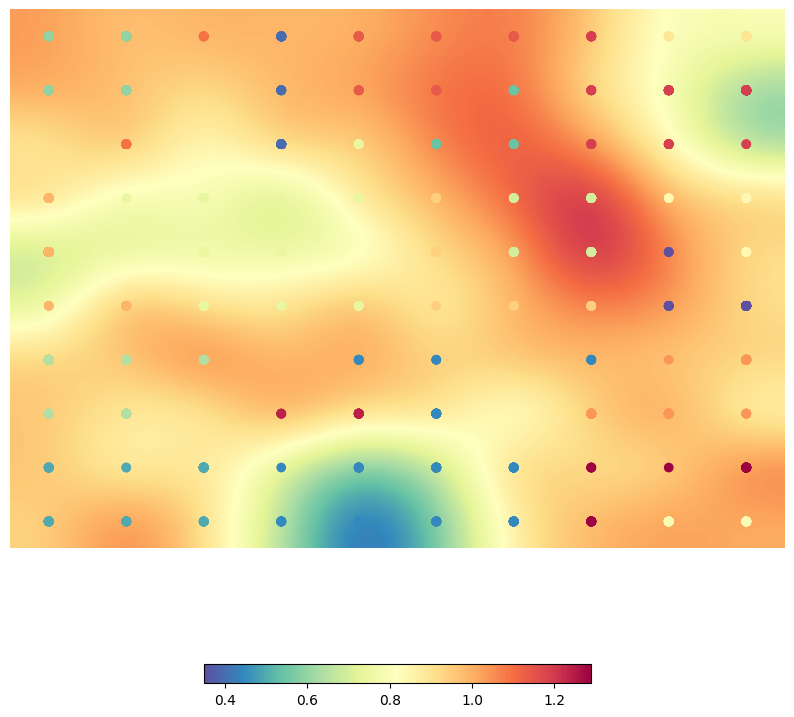

In [309]:
som.view_umatrix(bestmatches=True, colorbar=True,figsize=(10, 10)) 
matplotlib.pyplot.show()

In [310]:
print(som.clusters)

[[ 5  5 15  1 16 16 16 17 11 11]
 [ 5  5 15  1 16 16  4 17 17 17]
 [15 15  8  1  8  4  4 17 17 17]
 [13  8  8  8  8 12  7  7 10 10]
 [13 13  8  8  8 12  7  7  0 10]
 [13 13  8  8  8 12 12 12  0  0]
 [ 6  6  6  8  2  2 12  2 14 14]
 [ 6  6  6 18 18  2  2 14 14 14]
 [ 3  3  3  2  2  2  2 19 19 19]
 [ 3  3  3  2  2  2  2 19  9  9]]


Φαίνονται κυρίως κόκκινες περιοχές στον χάρτη και επομένως δεν έχουμε βρει καλές ομαδοποιήσεις, δηλαδή περιοχές που οι νευρώνες είναι κοντά μεταξύ τους και αποτυπώνονται με μπλε. Πρέπει να αυξήσουμε τον αριθμό των νευρώνων οπότε φτιάχνουμε ένα grid 30x30.

In [352]:
print("Clusters & # of their neurons ")
print("------------------------------")
values, counts = np.unique(som.clusters,return_counts=True)
sorted_counts = np.argsort(counts) 
values, counts = [list(values[sorted_counts]),list(counts[sorted_counts])]
for i, count in enumerate(counts):
    print(f"cluster {values[i]}: # {count} neurons")


Clusters & # of their neurons 
------------------------------
cluster 9: # 2 neurons
cluster 11: # 2 neurons
cluster 18: # 2 neurons
cluster 10: # 3 neurons
cluster 0: # 3 neurons
cluster 1: # 3 neurons
cluster 4: # 3 neurons
cluster 5: # 4 neurons
cluster 7: # 4 neurons
cluster 15: # 4 neurons
cluster 19: # 4 neurons
cluster 13: # 5 neurons
cluster 14: # 5 neurons
cluster 16: # 5 neurons
cluster 6: # 6 neurons
cluster 3: # 6 neurons
cluster 12: # 6 neurons
cluster 17: # 7 neurons
cluster 8: # 13 neurons
cluster 2: # 13 neurons



## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης του tf-idf, των εμφυτευμάτων και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. 

Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

Μπορείτε να υλοποιήσετε τη συνάρτηση αυτή όπως θέλετε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

In [480]:
def print_categories_stats(movie_IDs, printing = "whole"):
    categories_stats = []
    for id in movie_IDs:
        # split categories with , and remove spaces and " (! one movie can belong in > 1 category hence the list)
        category = (categories[id][0].replace(" ", "").replace('"', "") .split(","))
        categories_stats.extend(category)
    # count unique category labels
    unique_categ, counts = np.unique(categories_stats,  axis=0, return_counts = True) 
    # sort by decreasing count
    sorted_counts = np.argsort(counts)[::-1] 
    init = counts[sorted_counts[0]]
    stats = [(unique_categ[i], counts[i]) for i in sorted_counts]
    stat_print = []
    for elem in stats:
        if ((init/elem[1]) < 2):
            stat_print.append(elem)
    print('Overall Cluster Genres stats:')
    if printing == "whole":
        print(stats)
    elif printing == "first":
        print(stat_print)

    return stats

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

In [314]:
def print_cluster_neurons_movies_report(cluster_ID, bmus, som_model):
    cluster_bmus = np.column_stack(np.where(som_model.clusters==cluster_ID)[::-1])  # somoclu order 
    neuron = []
    for bmu in cluster_bmus:
        if bmu in bmus:
            neuron.append(bmu)
    
    return neuron

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

In [473]:
def neuron_movies_report(neurons, som_model, printing = "whole"):
    movie_ids = []
    for neuron in neurons:
        movie_ids.extend(list(np.where(np.all(neuron==som_model.bmus,axis=1))[0]))
    stats = print_categories_stats(movie_ids, printing)
    return movie_ids, stats

Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει. Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 

Παράδειγμα εξόδου για ένα cluster (μη βελτιστοποιημένος χάρτης, ωστόσο βλέπετε ότι οι μεγάλες κατηγορίες έχουν σημασιολογική  συνάφεια):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```

In [316]:
cluster_bmus = print_cluster_neurons_movies_report(7, bmus, som)
ids, stats = neuron_movies_report(cluster_bmus, som)

Overall Cluster Genres stats:
[('Action/Adventure', 59), ('Action', 57), ('Comedy', 34), ('Worldcinema', 20), ('MartialArtsFilm', 19), ('CrimeFiction', 17), ('ChineseMovies', 14), ('Adventure', 10), ('ActionComedy', 8), ('CrimeComedy', 7), ('Indie', 7), ('Western', 7), ('Superheromovie', 6), ('Warfilm', 6), ('Heist', 5), ('Black-and-white', 5), ('Fantasy', 5), ('Parody', 4), ('Comedy-drama', 4), ('Buddyfilm', 4), ('ScienceFiction', 4), ('Screwballcomedy', 4), ('Sports', 4), ('RomanceFilm', 3), ('Drama', 3), ('Superhero', 3), ('Thriller', 3), ('FamilyFilm', 3), ('ComedyofErrors', 2), ('Blackcomedy', 2), ('Wuxia', 2), ('FantasyAdventure', 2), ('ChaseMovie', 2), ('Musical', 2), ('Periodpiece', 2), ('Roadmovie', 2), ('AdventureComedy', 2), ('Slapstick', 2), ('B-Western', 1), ('Autoracing', 1), ('Animation', 1), ('Blaxploitation', 1), ('Bollywood', 1), ('Buddycop', 1), ('Airplanesandairports', 1), ('Caperstory', 1), ('AlienFilm', 1), ('EscapeFilm', 1), ("Children's/Family", 1), ('JapaneseMo

In [ ]:
print(som.clusters)

[[ 5  5 15  1 16 16 16 17 11 11]
 [ 5  5 15  1 16 16  4 17 17 17]
 [15 15  8  1  8  4  4 17 17 17]
 [13  8  8  8  8 12  7  7 10 10]
 [13 13  8  8  8 12  7  7  0 10]
 [13 13  8  8  8 12 12 12  0  0]
 [ 6  6  6  8  2  2 12  2 14 14]
 [ 6  6  6 18 18  2  2 14 14 14]
 [ 3  3  3  2  2  2  2 19 19 19]
 [ 3  3  3  2  2  2  2 19  9  9]]


In [398]:
clusterIDs = [3, 6, 17]
for clusterID in clusterIDs:
#for clusterID in range(20):
    print("Cluster ID: ", clusterID)
    bmus, indices = np.unique(som.bmus,axis=0,return_index=True)
    cluster_bmus = print_cluster_neurons_movies_report(clusterID, bmus, som_model = som)
    indices_, _ = neuron_movies_report(cluster_bmus, som_model = som)
    print("------------------------------------------------------------------------------------------------------------------------------------------------------------------------")

Cluster ID:  3
Overall Cluster Genres stats:
[('CrimeFiction', 100), ('Thriller', 91), ('Drama', 79), ('CrimeThriller', 51), ('Mystery', 47), ('Action', 34), ('Action/Adventure', 22), ('Black-and-white', 19), ('Suspense', 16), ('Filmnoir', 14), ('Comedy', 13), ('Detective', 10), ('Detectivefiction', 10), ('Indie', 9), ('Worldcinema', 9), ('Psychologicalthriller', 7), ('GangsterFilm', 7), ('Heist', 6), ('RomanceFilm', 6), ('CrimeDrama', 5), ('ActionThrillers', 5), ('Blackcomedy', 5), ('Supernatural', 5), ('Horror', 4), ('CourtroomDrama', 4), ('Filmadaptation', 4), ('ChineseMovies', 4), ('Caperstory', 3), ('Televisionmovie', 3), ('Spy', 3), ('Adventure', 3), ('Eroticthriller', 3), ('Cult', 3), ('Melodrama', 3), ('Periodpiece', 2), ('Buddyfilm', 2), ('MartialArtsFilm', 2), ('Fantasy', 2), ('Satire', 2), ('Romanticdrama', 2), ('Parody', 1), ('Avant-garde', 1), ('B-movie', 1), ('ChaseMovie', 1), ('NewHollywood', 1), ('Roadmovie', 1), ('Blaxploitation', 1), ('BritishNewWave', 1), ('Buddycop'

Μπορούμε να αντιληφθούμε ότι τα αποτελέσματα σημασιολογικά έχουν νόημα και ότι τοπολογικά χαρακτηριστικά έχουν εμφανιστεί. Clusters που είναι κοντά στον χάρτη αντιστοιχούν σε παρόμοιες κατηγορίες ενώ μεγαλύτερη απόσταση στον χάρτη συμβαδίζει με μεγαλύτερη διαφορά στο είδος των ταινιών που τα αντίστοιχα clusters αποτυπώνουν. Για παράδειγμα, τα clusters με IDs 6 και 3 που είναι κοντά στον χάρτη αποτυπώνουν Thriller και CrimeFiction/Thriller που είναι προφανώς πλήρως σχετικές μεταξύ τους, ενώ το cluster 17 που είναι μακρυά στον χάρτη αντιστοιχεί σε κωμωδία/οικογενειακή ταινία που είναι πολύ "μακρινό" ποιοτικά είδος.


## Tips για το SOM και το clustering

- Για την ομαδοποίηση ένα U-matrix καλό είναι να εμφανίζει και μπλε-πράσινες περιοχές (clusters) και κόκκινες περιοχές (ορίων). Παρατηρήστε ποια σχέση υπάρχει μεταξύ αριθμού ταινιών στο final set, μεγέθους grid και ποιότητας U-matrix.
- Για το k του k-Means προσπαθήστε να προσεγγίζει σχετικά τα clusters του U-matrix (όπως είπαμε είναι διαφορετικοί μέθοδοι clustering). Μικρός αριθμός k δεν θα σέβεται τα όρια. Μεγάλος αριθμός θα δημιουργεί υπο-clusters εντός των clusters που φαίνονται στο U-matrix. Το τελευταίο δεν είναι απαραίτητα κακό, αλλά μεγαλώνει τον αριθμό clusters που πρέπει να αναλυθούν σημασιολογικά.
- Σε μικρούς χάρτες και με μικρά final sets δοκιμάστε διαφορετικές παραμέτρους για την εκπαίδευση του SOM. Σημειώστε τυχόν παραμέτρους που επηρεάζουν την ποιότητα του clustering για το dataset σας ώστε να τις εφαρμόσετε στους μεγάλους χάρτες.
- Κάποια τοπολογικά χαρακτηριστικά εμφανίζονται ήδη σε μικρούς χάρτες. Κάποια άλλα χρειάζονται μεγαλύτερους χάρτες. Δοκιμάστε μεγέθη 20x20, 25x25 ή και 30x30 και αντίστοιχη προσαρμογή των k. Όσο μεγαλώνουν οι χάρτες, μεγαλώνει η ανάλυση του χάρτη αλλά μεγαλώνει και ο αριθμός clusters που πρέπει να αναλυθούν.


Επαναλαμβάνουμε την διαδικασία για ένα grid 40x40 (δοκιμάστηκαν και μικρότερα μεγέθη)  και πειραματιζόμαστε για τον αριθμό των clusters k του αλγορίθμου k-means. 

Στην έξοδο του προγράμματος (την 1η φορά γιατί μετά απλά το φορτώνουμε από το αντίστοιχο pickle αρχείο):
```
CPU times: total: 45min 15s
Wall time: 3min 34s
```
Τώρα ο υπολογισμός του SOM διαρκεί σημαντικά περισσότερο (παίρνει περίπου τον *30πλάσιο* χρόνο). Να σημειωθεί ότι πέραν την αύξηση του μεγέθους του χάρτη τώρα η εκπαίδευση γίνεται και με ολόκληρο το σύνολο των ταινιών (5000, όχι 2000).

In [569]:
# if it already exists load it 
# else train and save the result as pickle
try:
    som2 = joblib.load('som_large.pkl')
    print("Som (30 x 30 map) loaded ...")
except (OSError, IOError):
    # training for 100 epochs 
    n_rows, n_columns = 40,40 # 40 x 40 map
    som2 = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
    %time som2.train(final_set,epochs=100)   #δουλεύουμε με ολόκληρο το σύνολο των 5000 ταινιών (όχι μόνο 2000) !!!!
    print("Training for 100 epochs completed!")
    joblib.dump(som2, 'som_large.pkl')
    print("Saved result (as pickle) in ./som_large.pkl")

Som (30 x 30 map) loaded ...


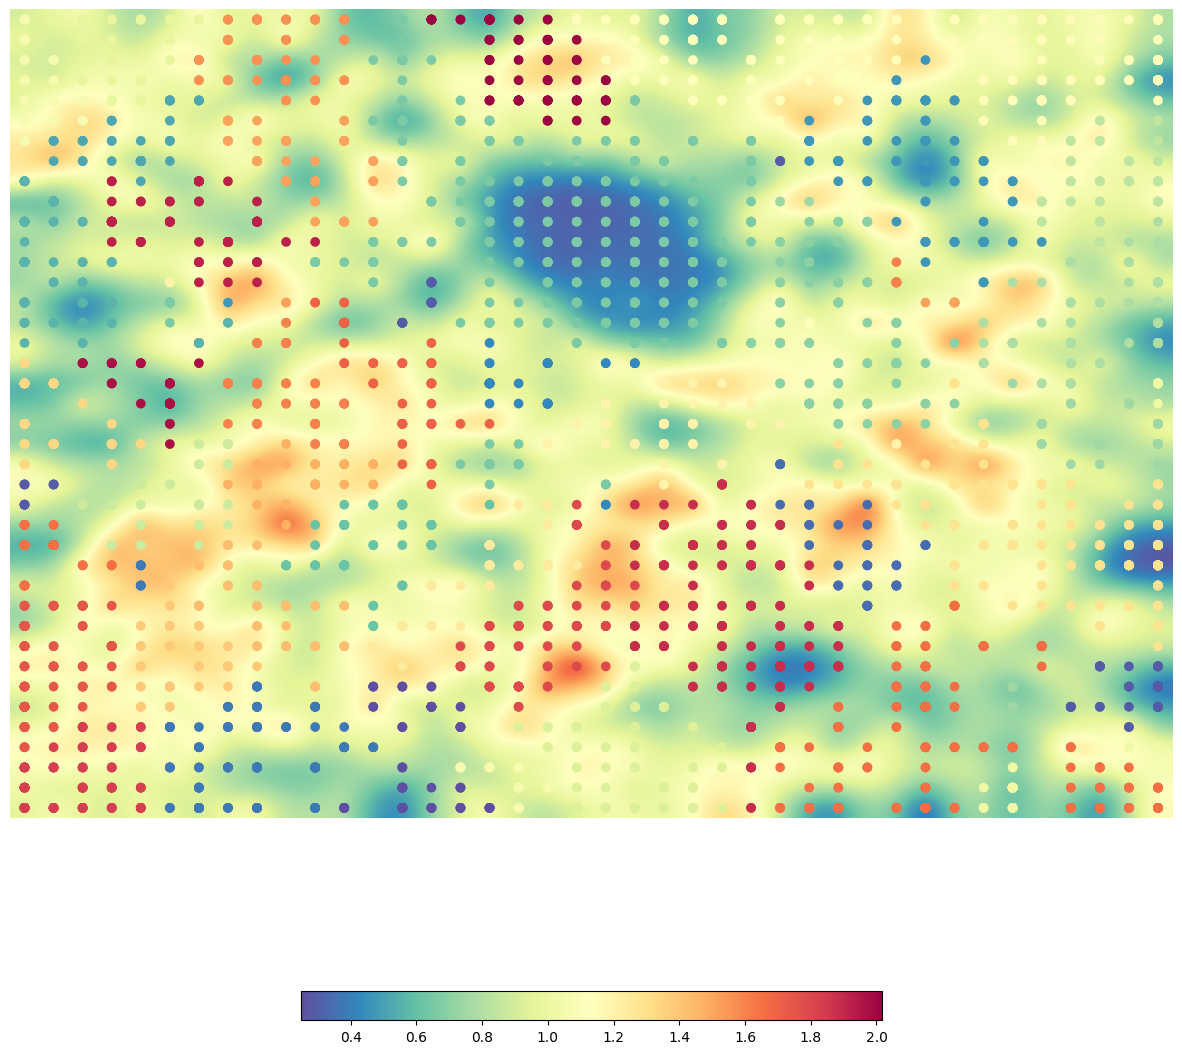

In [390]:
som2.cluster(KMeans(n_clusters=40, n_init='auto'))
bmus2, indices2 = np.unique(som2.bmus,axis=0,return_index=True)
som2.view_umatrix(bestmatches=True, colorbar=True,figsize=(15, 15))
matplotlib.pyplot.show()

Παρατηρούμε ότι στον χάρτη υπάρχουν σημαντικά περισσότερες μπλε περιοχές και πολύ λιγότερες κόκκινες που τις διαχωρίζουν. Επομένως, καταλαβαίνουμε ότι έχουμε τις διαφορετικές κατηγορίες να διαχωρίζονται όταν είναι "μακρινές" και για κάθε μία από αυτές διάφορες υποκατηγορίες που κοντά μεταξύ τους (στον χάρτη).

In [399]:
# clusterIDs = [3, 6, 17]
# for clusterID in range(30):
#     print("Cluster ID: ", clusterID)
#     bmus, indices = np.unique(som2.bmus,axis=0,return_index=True)
#     cluster_bmus = print_cluster_neurons_movies_report(clusterID, bmus, som_model = som2)
#     indices_, _ = neuron_movies_report(cluster_bmus, som_model = som2)
#     print("------------------------------------------------------------------------------------------------------------------------------------------------------------------------")

In [391]:
np.set_printoptions(threshold=sys.maxsize, linewidth=200)
print(som2.clusters)

[[18 16 16 16 16 16 16 29 29 29 29 29 29  9 39 39 39 39 39 19 19 19 19 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20]
 [18 18 16 16 16 16 29 29 29 29 29 29 29  9  9 39 39 39 39 39 19 19 19 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20]
 [18 18 16 16 16 16 29 29 29 29 29 29  9  9  9 39 39 39 39 39 19 19 19 19 19 19 19 19 19 19 19  5 20 20 20 20 20 20 20 20]
 [18 18 16 16 16 16 29 29 29 29 29 29  9  9  9 39 39 39 39 39 39 19 19 19 19 19 19 19 19 19  5  5 20 20 20 20 20 20 20 20]
 [18 18 18 16 16  6  6 29 29 29 29 29  9  9  9  9 39 39 39 39 39  9 19 19 19 19 19 19 19  5  5  5  5 20 20 20 20 20 20 20]
 [18 18 18  6  6  6  6 28 28 28 28 28  9  9  9  9  9 39 39 39 39  9  9  9 19  9 19  5  5  5  5  5  5 20 20 20 20 13 13 13]
 [18  6  6  6  6  6  6 28 28 28 28 28 28  9  9  9  9  9  9  9  9  9  9  9  9  9  9  5  5  5  5  5  5 20 20 20 13 13 13 13]
 [ 7  6  6  6  6  6 37 28 28 28 28 28 28  9  9  9  9  9  9  9  9  9  9  9  9  9  1  5  5  5  5  5  5  5 20 20 13 13 13 13]
 [ 7  7  7 37  6

In [392]:
print("clusters & # of their neurons")
print("------------------------------")
values, counts = np.unique(som2.clusters,return_counts=True)
sorted_counts = np.argsort(counts) 
values, counts = [list(values[sorted_counts]),list(counts[sorted_counts])]
for i, count in enumerate(counts):
    print(f"cluster {values[i]}: # {count} neurons")

clusters & # of their neurons
------------------------------
cluster 17: # 15 neurons
cluster 6: # 18 neurons
cluster 27: # 18 neurons
cluster 38: # 19 neurons
cluster 16: # 20 neurons
cluster 35: # 22 neurons
cluster 4: # 22 neurons
cluster 25: # 22 neurons
cluster 24: # 22 neurons
cluster 18: # 25 neurons
cluster 14: # 25 neurons
cluster 2: # 26 neurons
cluster 13: # 26 neurons
cluster 11: # 28 neurons
cluster 26: # 29 neurons
cluster 33: # 29 neurons
cluster 39: # 30 neurons
cluster 29: # 30 neurons
cluster 8: # 30 neurons
cluster 30: # 31 neurons
cluster 22: # 31 neurons
cluster 0: # 31 neurons
cluster 1: # 32 neurons
cluster 32: # 32 neurons
cluster 37: # 34 neurons
cluster 34: # 37 neurons
cluster 28: # 37 neurons
cluster 21: # 38 neurons
cluster 7: # 41 neurons
cluster 15: # 42 neurons
cluster 12: # 45 neurons
cluster 3: # 46 neurons
cluster 20: # 50 neurons
cluster 19: # 53 neurons
cluster 5: # 57 neurons
cluster 10: # 60 neurons
cluster 36: # 83 neurons
cluster 23: # 89 neuron

In [393]:
clusterID = 10
bmus2, indices2 = np.unique(som2.bmus,axis=0,return_index=True)
cluster_bmus = print_cluster_neurons_movies_report(clusterID, bmus2, som_model = som2)
indices_,_ = neuron_movies_report(cluster_bmus, som_model = som2)

Overall Cluster Genres stats:
[('Comedy', 121), ('Drama', 120), ('Comedy-drama', 63), ('Indie', 25), ('Blackcomedy', 21), ('Worldcinema', 12), ('Filmadaptation', 12), ('FamilyDrama', 10), ('Comingofage', 10), ('Periodpiece', 9), ('Teen', 9), ('Satire', 7), ('EnsembleFilm', 7), ('Buddyfilm', 7), ('Sports', 6), ('CrimeFiction', 6), ('ChineseMovies', 5), ('Black-and-white', 5), ('FamilyFilm', 5), ('Warfilm', 4), ('Roadmovie', 4), ('JapaneseMovies', 4), ('Comedyofmanners', 4), ('Thriller', 4), ('Mystery', 3), ('Melodrama', 3), ('DomesticComedy', 3), ('Tragicomedy', 3), ('Politicaldrama', 3), ('Artfilm', 3), ('ShortFilm', 3), ('Silentfilm', 3), ('Adventure', 3), ('Fantasy', 3), ('WorkplaceComedy', 2), ('CrimeComedy', 2), ('Biographicalfilm', 2), ('Cult', 2), ('Docudrama', 2), ('Americana', 2), ('Action/Adventure', 2), ('Surrealism', 2), ('Music', 2), ('Parody', 2), ('Horror', 2), ('Romanticdrama', 2), ('MarriageDrama', 2), ('Musical', 2), ('MediaSatire', 2), ('GangsterFilm', 1), ('Boxing', 

Εκτυπώνοντας τις πληροφορίες για κάποια ενδεικτικά clusters παρατηρούμε ότι έχουμε εντοπίσει σε σχέση με προηγουμένως περισσότερες κατηγορίες (π.χ. Musical/Comedy). Βέβαια κάποιες κατηγορίες εμφανίζονται περισσότερες από μία φορές χωρίς κάποια ιδιαίτερη διαφοροποίηση. Αυτό όπως θα δούμε στην συνέχεια είναι λογικό για τις μεγάλες κατηγορίες. 



## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Μετά το πέρας της εκπαίδευσης και του clustering θα έχετε ένα χάρτη με τοπολογικές ιδιότητες ως προς τα είδη των ταίνιών της συλλογής σας, κάτι αντίστοιχο με την εικόνα στην αρχή της Εφαρμογής 2 αυτού του notebook. Η συγκεκριμένη εικόνα είναι μόνο για εικονογράφιση, δεν είναι χάρτης SOM καιδεν έχει καμία σχέση με τη συλλογή δεδομένων και τις κατηγορίες μας.

Για τον τελικό χάρτη SOM που θα παράξετε για τη συλλογή σας, αναλύστε σε markdown με συγκεκριμένη αναφορά σε αριθμούς clusters και τη σημασιολογική ερμηνεία τους τις εξής τρεις τοπολογικές ιδιότητες του SOM: 

1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.
2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.
3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Προφανώς τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας.

Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.


Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.


#### 1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.

Προσδιορίζουμε τις κατηγορίες που εμφανίζονται στο πλήρες σύνολο των 5000 ταινιών που έχουμε στην διάθεσή μας και την συχνότητα εμφάνισης της κάθε μίας από αυτές.

In [455]:
cat_set = []

for movie in range(5000):
    cats = (categories[movie][0].replace(" ", "").replace('"', "")).split(",")
    cat_set.extend(cats)

# Create a dictionary of distinct categories and their frequencies
cat_freqs = {i:cat_set.count(i) for i in set(cat_set)}

# Sort Dictionary wrt to most common categories
cat_freqs_sorted = sorted(cat_freqs.items(), key=lambda cat_freqs: -cat_freqs[1])
print("Most frequent:", cat_freqs_sorted[:15])
print()
print("Least frequent (only once):", cat_freqs_sorted[-38:])

Most frequent: [('Drama', 2282), ('Comedy', 1232), ('Thriller', 778), ('RomanceFilm', 743), ('Action', 704), ('Worldcinema', 598), ('CrimeFiction', 521), ('Horror', 518), ('Black-and-white', 465), ('Action/Adventure', 434), ('Indie', 412), ('Adventure', 393), ('ShortFilm', 387), ('FamilyFilm', 381), ('Romanticdrama', 293)]

Least frequent (only once): [('Concertfilm', 1), ('SciencefictionWestern', 1), ('Werewolffiction', 1), ('Outlaw', 1), ('Spacewestern', 1), ('SciFiPicturesoriginalfilms', 1), ('Legaldrama', 1), ('InterpersonalRelationships', 1), ('Archivesandrecords', 1), ('SwordandSandal', 1), ('Supermarionation', 1), ('Kitchensinkrealism', 1), ("Children'sEntertainment", 1), ('BritishEmpireFilm', 1), ('Animals', 1), ("Children'sIssues", 1), ('Roadshow/Carny', 1), ('Language&Literature', 1), ('Existentialism', 1), ('ColdWar', 1), ('FantasyDrama', 1), ('Samuraicinema', 1), ('CourtroomComedy', 1), ('HistoricalDocumentaries', 1), ('WorldHistory', 1), ('GenderIssues', 1), ('EarlyBlackCi

Παρατηρούμε ότι οι πιο συνηθισμένες κατηγορίες είναι : Drama, Comedy, Thriller, Romance Film, Action.

 Οι πιο σπάνιες κατηγορίες είναι αυτές που εμφανίζονται λιγότερες φορές και υπάρχουν αρκετές που εμφανίζονται μόνο 1 φορά (π.χ. FantasyDrama, Zmovie, κτλ).

In [453]:
# Create Array of Distinct Categories
distinct_categories = np.array([tupl[0] for tupl in cat_freqs_sorted])
total_neurons_per_cat = {}
# Print activated categories for each of the 30 clusters
for clusterID in range(40):
    ID_list, stats = neuron_movies_report([clusterID],som_model = som2)
    for stat in stats:
        if stat[0] in total_neurons_per_cat:
            total_neurons_per_cat[stat[0]] += stat[1]
        else:
            total_neurons_per_cat[stat[0]] = stat[1]

total_neurons_per_cat = sorted(total_neurons_per_cat.items(), key=lambda total_neurons_per_cat: -total_neurons_per_cat[1])


Overall Cluster Genres stats:
[('Thriller', 18), ('Mystery', 18), ('Drama', 18), ('Suspense', 5), ('Psychologicalthriller', 5), ('RomanceFilm', 2), ('Politicalthriller', 2), ('Teen', 1), ('Sports', 1), ('Socialproblemfilm', 1), ('Melodrama', 1), ('JapaneseMovies', 1), ('History', 1), ('Filmadaptation', 1), ('Comedy-drama', 1), ('Blackcomedy', 1)]
Overall Cluster Genres stats:
[]
Overall Cluster Genres stats:
[('Thriller', 2), ('Mystery', 2), ('Drama', 2), ('CrimeThriller', 2), ('CrimeFiction', 2), ('CrimeDrama', 2), ('Melodrama', 1), ('Indie', 1), ('EnsembleFilm', 1)]
Overall Cluster Genres stats:
[('Thriller', 2), ('Drama', 2), ('CrimeThriller', 2), ('CrimeFiction', 2), ('CrimeDrama', 2), ('Black-and-white', 2), ('Worldcinema', 1), ('Mystery', 1), ('GangsterFilm', 1), ('Filmnoir', 1), ('Caperstory', 1), ('Artfilm', 1)]
Overall Cluster Genres stats:
[('Thriller', 5), ('Filmnoir', 5), ('CrimeFiction', 5), ('Black-and-white', 5), ('Drama', 4), ('Suspense', 1), ('Psychologicalthriller', 1

In [456]:
print("Format : (Είδος ταινίας, # νευρώνων)")
most_list = []
for i in range(7):
    most_list.append(total_neurons_per_cat[i])
print('Είδη που ενεργοποιούν περισσότερους νευρώνες', most_list)

few = 10
few_list = []
for i in range(1,few+1):
    few_list.append(total_neurons_per_cat[-i])
print('Είδη που ενεργοποιούν λιγότερους νευρώνες',few_list)

Format : (Είδος ταινίας, # νευρώνων)
Είδη που ενεργοποιούν περισσότερους νευρώνες [('Drama', 50), ('Thriller', 28), ('Mystery', 23), ('Documentary', 19), ('Culture&Society', 14), ('Comedyfilm', 13), ('Horror', 12)]
Είδη που ενεργοποιούν λιγότερους νευρώνες [('Biographicalfilm', 1), ('Rockumentary', 1), ('Music', 1), ('Language&Literature', 1), ('InterpersonalRelationships', 1), ('Illnesses&Disabilities', 1), ('Warfilm', 1), ('Travel', 1), ('Avant-garde', 1), ('Experimentalfilm', 1)]


Παρατηρούμε ότι οι κατηγορίες με μεγαλύτερες συχνότητες εμφάνισης, όπως Drama, Thriller, Comedy τείνουν να απεικονίζονται σε περισσότερους νευρώνες : 50, 28 KAI 13 αντίστοιχα, ενώ πιο σπάνιες κατηγορίες ενεργοποιούν οριακά έναν νευρώνα (π.χ. ZombieFilm, Roadmovie).

#### 2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.

In [ ]:
clusterID = 30
bmus2, indices2 = np.unique(som2.bmus,axis=0,return_index=True)
cluster_bmus = print_cluster_neurons_movies_report(clusterID, bmus2, indices2, som_model = som2)
indices_,_ = neuron_movies_report(cluster_bmus, som_model = som2)

Overall Cluster Genres stats:
[('Romance Film', 21), ('Comedy', 21), ('Romantic comedy', 9), ('Black-and-white', 8), ('Musical', 7), ('Screwball comedy', 3), ('Musical comedy', 2), ('Sports', 2), ('Western', 1), ("Children's/Family", 1), ('Adventure', 1), ('Beach Film', 1), ('Boxing', 1), ('Fantasy', 1), ('Comedy film', 1), ('Crime Fiction', 1), ('Sex comedy', 1), ('Slapstick', 1), ('Action', 1)]


In [464]:
clusterIDs = [18, 17, 1]
for clusterID in clusterIDs:
    print("clusterID", clusterID)
    bmus2, indices2 = np.unique(som2.bmus,axis=0,return_index=True)
    cluster_bmus = print_cluster_neurons_movies_report(clusterID, bmus2, som_model = som2)
    indices_,_ = neuron_movies_report(cluster_bmus, som_model = som2)
    print("----------------------------------------------------------------------------------")


clusterID 18
Overall Cluster Genres stats:
[('Thriller', 108), ('Mystery', 100), ('CrimeThriller', 75), ('CrimeFiction', 55), ('Drama', 49), ('Psychologicalthriller', 33), ('Suspense', 32), ('Detective', 16), ('Indie', 13), ('Action', 10), ('Detectivefiction', 10), ('Filmadaptation', 10), ('Comedy', 9), ('Eroticthriller', 7), ('Worldcinema', 6), ('Televisionmovie', 5), ('Black-and-white', 5), ('Politicalthriller', 4), ('Filmnoir', 4), ('RomanceFilm', 4), ('Slasher', 3), ('Horror', 3), ('GangsterFilm', 2), ('Sports', 2), ('Blackcomedy', 2), ('Warfilm', 2), ('Supernatural', 2), ('Adventure', 2), ('Neo-noir', 2), ('Periodpiece', 2), ('Politicaldrama', 2), ('JapaneseMovies', 2), ('ComedyThriller', 1), ('Comedy-drama', 1), ('Comedyfilm', 1), ('Remake', 1), ('ChaseMovie', 1), ('Caperstory', 1), ('CrimeDrama', 1), ('Bollywood', 1), ('Avant-garde', 1), ('Action/Adventure', 1), ('Comingofage', 1), ('Socialproblemfilm', 1), ('Teen', 1), ('Surrealism', 1), ('Spy', 1), ('EnsembleFilm', 1), ('Exper


Παρατηρούμε με κάποιες ενδεικτικές δοκιμές ότι μακρινά πρότυπα εισόδου απεικονίζονται σε μακρινούς νευρώνες. Για παράδειγμα, για τους clusters 18 και 17 που είναι πολύ απομακρυσμένοι στον χάρτη (αποτυπώνονται σε αντιδιαμετρικές γωνίες του) ισχύει ότι απεικονίζουν thriller/mystery η πρώτη την στιγμή που η άλλη απεικονίζει ρομαντική κομεντί. Δηλαδή μακρινά πρότυπα εισόδου. 
Προφανώς η διαδικασία δεν είναι τέλεια (υπάρχουν και εξαιρέσεις στην παρατήρηση αυτή). 

#### 3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.



In [505]:
clusterIDs = [16, 29, 22, 34, 12,9, 32, 39]
for clusterID in clusterIDs:
    print("clusterID", clusterID)
    bmus2, indices2 = np.unique(som2.bmus,axis=0,return_index=True)
    cluster_bmus = print_cluster_neurons_movies_report(clusterID, bmus2, som_model = som2)
    indices_,_ = neuron_movies_report(cluster_bmus, som_model = som2, printing="first")
    print("----------------------------------------------------------------------------------")


clusterID 16
Overall Cluster Genres stats:
[('Thriller', 87), ('Drama', 86), ('CrimeFiction', 85)]
----------------------------------------------------------------------------------
clusterID 29
Overall Cluster Genres stats:
[('CrimeFiction', 114), ('Drama', 113)]
----------------------------------------------------------------------------------
clusterID 22
Overall Cluster Genres stats:
[('ScienceFiction', 64)]
----------------------------------------------------------------------------------
clusterID 34
Overall Cluster Genres stats:
[('Horror', 83), ('ScienceFiction', 82)]
----------------------------------------------------------------------------------
clusterID 12
Overall Cluster Genres stats:
[('Comedy', 140), ('Romanticcomedy', 138), ('RomanceFilm', 127)]
----------------------------------------------------------------------------------
clusterID 9
Overall Cluster Genres stats:
[('Drama', 612)]
----------------------------------------------------------------------------------
c

Παρατηρούμε μέσω κάποιων ενδεικτικών ελέγχων ότι γενικά κοντινά πρότυπα εισόδου τείνουν απεικονίζονται σε κοντινά clusters στο επίπεδο. Για παράδειγμα τα clusters 22, 34 που είναι κοντινά απεικονίζουν ταινίες Science Fiction και Horror/Science Fiction αντίστοιχα, δηλαδή σημασιολογικά πολύ κοντινά πρότυπα εισόδου. Άλλο παράδειγμα είναι οι κοντινοί clusters 16, 29 που απεικονίζουν Thriller/Drama και Crime Fiction/Drama που είναι παρεμφερής κατηγορίες. Μπορούμε επίσης να δούμε ενδεικτικά τον cluster 9 να απεικονίζει την γενικότερη "δημοφιλή" κατηγορία Drama την στιγμή που τα γειτονικά clusters αναπαριστούν διάφορες υποκατηγορίες-εξειδικεύσεις του είδους όπως για παράδειγμα το 39 που είναι Drama/Warfilm, το 21 που είναι Drama/Family Film, κτλ. 

#### Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.

 Από εδώ και κάτω αναφερόμαστε σε διαφορετικά clusters καθώς αναγκαστήκαμε να ξανατρέξουμε τον κώδικα και το clustering επαναλήφθηκε (αρχικοποιείται τυχαία).

[[32 39 39 28 28 28 28 28 28 28  1  1  1  1  1  4  4  4  4 14 14 14 14 14 14 14 14 14 14 14 14 19 19 19 19 19 34 34 34 34]
 [39 39 39 39 28 28 28 28 28 28  1  1  1  1  1  4  4  4  4 14 14 14 14 14 14 14 14 14 14 14 14 19 19 19 19 19 34 34 34 34]
 [39 39 39 39 39 28 28 28 28 28 28  1  1  1  1  4  4  4  4  4 14 14 14 14 14 14 14 14 14 14 14 19 19 19 19 19 34 34 34 34]
 [39 39 39 39 39 28 28 28 28 28 28 28  1  1  1  4  4  4  4  4  4 14 14 14 14 14 14 14 14 14 19 19 19 19 19 19 19 34 34 34]
 [39 39 39 39 28 28 28 28 28 28 28 28 32 32 32  4  4  4  4  4  4  4 14 14 14 14 14 14 14 19 19 19 19 19 19 19 19 34 34 34]
 [39 39 39 32 32 28 28 28 28  4 32 32 32 32 32  4  4  4  4  4  4  4  4  4 14  4 14 19 19 19 19 19 19 19 19 19 19 38 38 38]
 [28 39 32 32  2  2 28  4  4  4 32 32 32 32 32  4  4  4  4  4  4  4  4  4  4  4  4 19 19 19 19 19 19 19 19 19 38 38 38 38]
 [ 2  2  2  2  2  2 23 23  4  4  4 32 32 32 32  4  4  4  4  4  4  4  4  4  4  4  4 19 19 19 19 19 19 19 19 19 38 38 38 38]
 [ 2  2  2  2  2

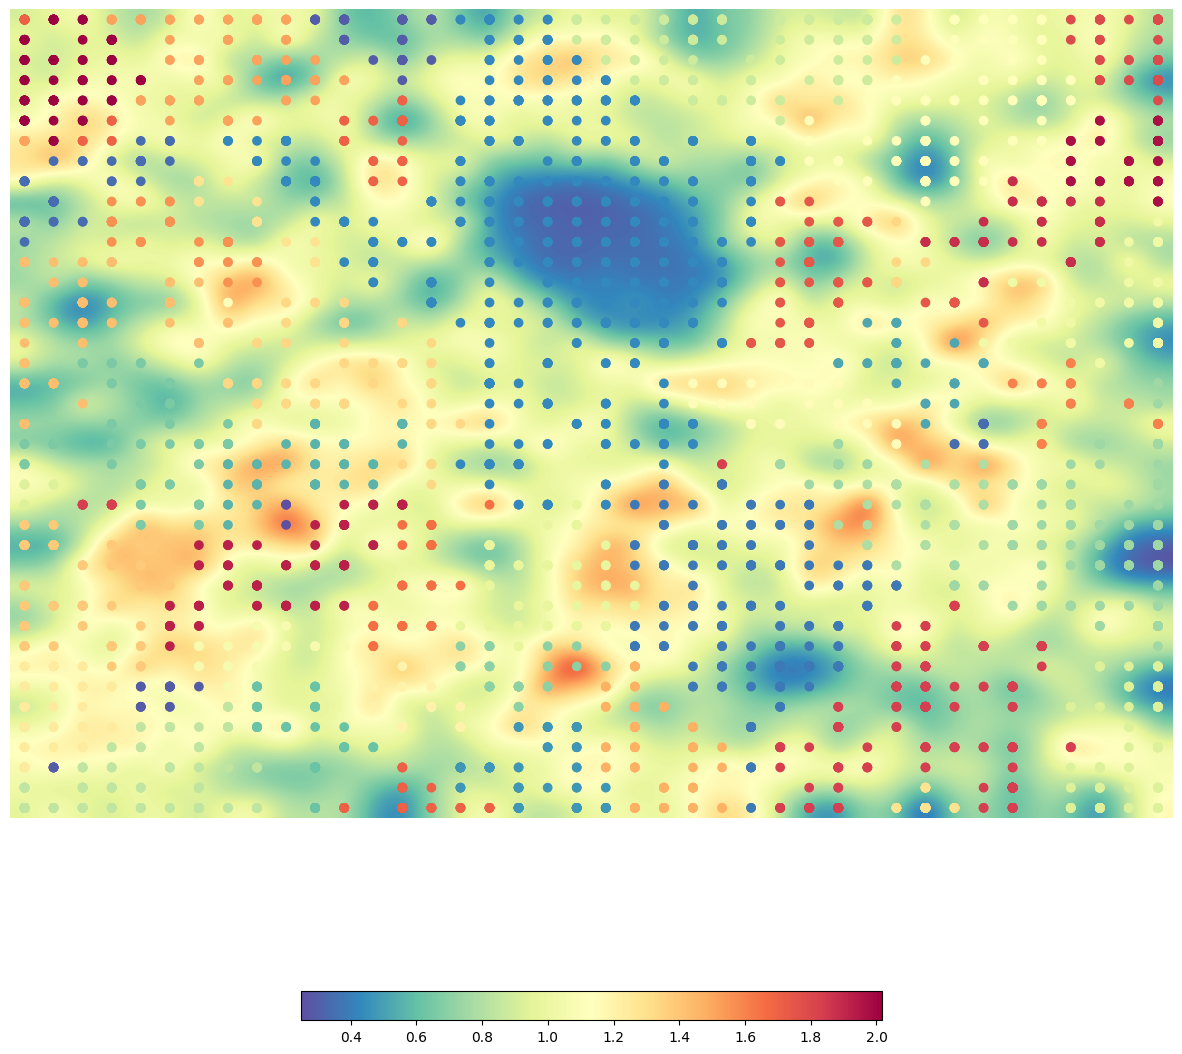

In [627]:
som2.cluster(KMeans(n_clusters=40, n_init='auto', random_state = 21))
bmus2, indices2 = np.unique(som2.bmus,axis=0,return_index=True)
print(som2.clusters)
som2.view_umatrix(bestmatches=True, colorbar=True,figsize=(15, 15))
matplotlib.pyplot.show()


In [637]:
clusterID =  27
bmus2, indices2 = np.unique(som2.bmus,axis=0,return_index=True)
cluster_bmus = print_cluster_neurons_movies_report(clusterID, bmus2, som_model = som2)
indices_,_ = neuron_movies_report(cluster_bmus, som_model = som2)

Overall Cluster Genres stats:
[('Horror', 86), ('Thriller', 83), ('Psychologicalthriller', 27), ('Drama', 23), ('Worldcinema', 20), ('Supernatural', 20), ('Slasher', 6), ('Teen', 5), ('Indie', 5), ('Fantasy', 5), ('Mystery', 4), ('Naturalhorrorfilms', 4), ('FilipinoMovies', 4), ('Eroticthriller', 4), ('CrimeFiction', 4), ('CreatureFilm', 4), ('JapaneseMovies', 4), ('RomanceFilm', 3), ('Black-and-white', 3), ('Adventure', 3), ('Filmadaptation', 3), ('ZombieFilm', 2), ('Cult', 2), ('CostumeHorror', 2), ('Comedy', 2), ('B-movie', 2), ('CrimeThriller', 2), ('HauntedHouseFilm', 2), ('Action', 2), ('Suspense', 2), ('Silentfilm', 1), ('Warfilm', 1), ('AnimalPicture', 1), ('Televisionmovie', 1), ('Tamilcinema', 1), ('Blackcomedy', 1), ('ChineseMovies', 1), ('Comedyfilm', 1), ('Comedyhorror', 1), ('Surrealism', 1), ('CourtroomDrama', 1), ('GothicFilm', 1), ('Giallo', 1), ('Romanticfantasy', 1), ('Romanticdrama', 1), ('Remake', 1), ('Documentary', 1), ('Musical', 1), ('Music', 1), ('FamilyDrama'

In [639]:
clusterIDs = [3, 5, 10, 35]
for clusterID in clusterIDs:
    print("clusterID", clusterID)
    bmus2, indices2 = np.unique(som2.bmus,axis=0,return_index=True)
    cluster_bmus = print_cluster_neurons_movies_report(clusterID, bmus2, som_model = som2)
    indices_,_ = neuron_movies_report(cluster_bmus, som_model = som2, printing="first")
    print("----------------------------------------------------------------------------------")

clusterID 3
Overall Cluster Genres stats:
[('Horror', 242)]
----------------------------------------------------------------------------------
clusterID 5
Overall Cluster Genres stats:
[('Thriller', 78), ('Mystery', 58), ('CrimeThriller', 47)]
----------------------------------------------------------------------------------
clusterID 10
Overall Cluster Genres stats:
[('ScienceFiction', 32), ('Horror', 32), ('Thriller', 26)]
----------------------------------------------------------------------------------
clusterID 35
Overall Cluster Genres stats:
[('RomanceFilm', 45), ('JapaneseMovies', 42), ('Musical', 33), ('ChineseMovies', 30)]
----------------------------------------------------------------------------------


Παρατηρούμε ότι το cluster ενεργοποιεί κατηγορίες που δεν είναι κοντινές όπως Romance, Drama, Comedy, Musical και Slasher, Horror, Creature Film και έτσι φαίνεται να μην έχει αυστηρά καθορισμένα χαρακτηριστικά. Προκειμένου να αποκτήσουμε σαφέστερη εικόνα για το cluster αυτό εξετάζουμε τα γειτονικά clusters. Παρατηρούμε ότι τα clusters αυτά (τα συγκεκριμένα IDs φαίνονται στον παραπάνω κώδικα) είναι όλα θρίλερ και horror (τρομακτικές ταινίες) εκτός από το cluster 35 που είναι Romance, Musical (ανάλαφρη κατηγορία). Στους νευρώνες του cluster 27 αποδίδονται ταινίες που είναι thriller αλλά έχουν και ρομαντικά στοιχεία. Έτσι είναι ομαλή η μετάβαση μεταξύ των 2 διαφορετικών κατηγοριών και προκύπτει παράλληλα αυτό το μικρό cluster με κάπως ασαφή χαρακτηριστικά το οποίο λειτουργεί ως "γέφυρα"-ενδιάμεση μετάβαση μεταξύ τρομακτικών ταινιών και των πολύ πιο ανάλαφρων ποιοτικά ρομαντικών musical.
To cluster 4 είναι πολύ μεγάλο και είναι η γενικότερη κατηγορία των δραματικών ταινιών. Στην γειτονιά του έχουμε υπο-κατηγορίες του είδους. Συγκεκριμένα τα cluster 32, 1, 14, 19, 20, και 24 αντιστοιχούν στα Thriller Drama, Action Drama, Worldcinema Drama, Romance Drama, Indie Drama/Comedy, Family Film Drama αντίστοιχα. Μπορούμε να βρούμε προφανώς και άλλα τέτοια παραδείγματα.

In [643]:
clusterIDs = [32, 1, 14, 19, 20, 24]
for clusterID in clusterIDs:
    print("clusterID", clusterID)
    bmus2, indices2 = np.unique(som2.bmus,axis=0,return_index=True)
    cluster_bmus = print_cluster_neurons_movies_report(clusterID, bmus2, som_model = som2)
    indices_,_ = neuron_movies_report(cluster_bmus, som_model = som2, printing="first")
    print("----------------------------------------------------------------------------------")

clusterID 32
Overall Cluster Genres stats:
[('Thriller', 127), ('Drama', 65)]
----------------------------------------------------------------------------------
clusterID 1
Overall Cluster Genres stats:
[('Action', 90), ('Drama', 86)]
----------------------------------------------------------------------------------
clusterID 14
Overall Cluster Genres stats:
[('Worldcinema', 204), ('Drama', 187)]
----------------------------------------------------------------------------------
clusterID 19
Overall Cluster Genres stats:
[('RomanceFilm', 220), ('Drama', 218)]
----------------------------------------------------------------------------------
clusterID 20
Overall Cluster Genres stats:
[('Indie', 47), ('Drama', 44), ('Comedy', 41), ('Comedy-drama', 27)]
----------------------------------------------------------------------------------
clusterID 24
Overall Cluster Genres stats:
[('FamilyFilm', 132), ('Drama', 78)]
-----------------------------------------------------------------------------

#### Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.

Ιδιαίτερο ενδιαφέρον έχουν τα παρακάτω clusters. Αναγράφεται δίπλα στο καθένα η κατηγορία που απεικονίζει. 

* cluster 3 : Horror
* cluster 4 : Drama
* cluster 11 : Comedy
* cluster 35 : Romance
* cluster 9 : Animation
* cluster 13 : Action

Αυτά είναι και τα clusters που αποτελούν τις πιο μπλε περιοχές του χάρτη απεικόνισης και οι πιο συχνά εμφανιζόμενες κατηγορίες ταινιών όπως είδαμε και παραπάνω (Drama, Comedy, Thriller, Romance Film, Action). Δεδομένου ότι στις πιο συχνά εμφανιζόμενες κατηγορίες, δηλαδή οι Drama, Comedy, Thriller, Romance Film, Action υπάρχουν πολλές ταινίες στο dataset. Έτσι, τα clusters αυτά θα ενεργοποιούνται για το μεγαλύτερο πλήθος ταινιών εισόδου και αναμένεται ότι θα βρίσκουμε πολλές υποκατηγορίες τους (π.χ. ρομαντικές κομεντί, ρομαντικά δράματα, crime δράματα, science fiction thriller, thriller mystery, κτλ).

Παραθέτουμε την τοποθέτηση των clusters σε μορφή "διαγράμματος" κατηγοριών αντίστοιχου με αυτού που δόθηκε στην εκφώνηση.

![Movie - cluster map](./movie_map.png)

Ακόμα παρατηρούμε ότι τα short films είναι στην περιοχή των Animation, Black-and-White και των Drama. Αυτό είναι λογικό. Είναι πιο σύνηθες Black-and-White ταινίες ρομαντικές, κωμωδίες ή horror με βάση τις εκτενής δοκιμές στο dataset που έχουν προηγηθεί στα πλαίσια των προηγούμενων ερωτημάτων οπότε θα περιμέναμε ίσως να είναι στην περιοχή του χάρτη κάτω δεξιά. Επίσης, παρατηρούμε ότι υπάρχει μόνο μία κατηγορία με Documentaries, η Documentary/Comedy. Τα documentaries είναι κάπως πιο μακρυά από τις υπόλοιπες κατηγορίες και δεν είναι εύκολο να μπει στην σωστή γειτονιά. Η ομαδοποίησή της με την Comedy είναι σχετικά ικανοποιητική. 

In [644]:
clusterIDs = [9, 36, 5, 3]

#for clusterID in clusterIDs:
for clusterID in range(40):
    print("clusterID", clusterID)
    bmus2, indices2 = np.unique(som2.bmus,axis=0,return_index=True)
    cluster_bmus = print_cluster_neurons_movies_report(clusterID, bmus2, som_model = som2)
    indices_,_ = neuron_movies_report(cluster_bmus, som_model = som2, printing="first")
    print("----------------------------------------------------------------------------------")


clusterID 0
Overall Cluster Genres stats:
[('FamilyFilm', 4), ('Fantasy', 4), ('Adventure', 4), ('MythologicalFantasy', 4), ("Children'sFantasy", 4), ('Animation', 3), ("Children's/Family", 3)]
----------------------------------------------------------------------------------
clusterID 1
Overall Cluster Genres stats:
[('Action', 90), ('Drama', 86)]
----------------------------------------------------------------------------------
clusterID 2
Overall Cluster Genres stats:
[('Black-and-white', 100), ('Comedy', 76), ('ShortFilm', 52)]
----------------------------------------------------------------------------------
clusterID 3
Overall Cluster Genres stats:
[('Horror', 242)]
----------------------------------------------------------------------------------
clusterID 4
Overall Cluster Genres stats:
[('Drama', 795)]
----------------------------------------------------------------------------------
clusterID 5
Overall Cluster Genres stats:
[('Thriller', 78), ('Mystery', 58), ('CrimeThriller'